# 6. Plot All Results

gg-napari-env

In [427]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import regionprops
from napari_czifile2 import napari_get_reader
from skimage import io
import os 
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [428]:
def plot_2_channels(results, c1, c2, c1_name, c2_name, c1_color, c2_color, coordinates, 
                    image, metadata, all_rois, cell_borders, input, file, 
                    pixel_bounds=100, bbox_expansion=5, 
                    dapi_max=255, c1_max=255, c2_max=255): 
    
    # Remove -T from column names
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name}-{c2_name}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 400) 
    sns.scatterplot(data=results[(results[c1] < 1.45) & (results[c2] < 1.45)], x=c1, y=c2, s=2, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[(results['image'] == file)].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{c1_name}", fontsize=6) 
    ax.set_ylabel(f"{c2_name}", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(-0.05, 1.55) 
    ax.set_xlim(-0.05, 1.55)
    ax.set_xticks([0, 0.5, 1, 1.5])
    ax.set_yticks([0, 0.5, 1, 1.5])

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    # Remove -border from c1 and c2 names
    c1 = c1.split('-')[0]
    c2 = c2.split('-')[0]

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)
        
        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # -- Cyan (c2): add to green and blue
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1.0   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='regular')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='regular')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='regular')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))
        
        """# Plot cell border on zoom panel in red 
        # Get cell border 
        cell_border = cell_borders[cell['z'], :, :] == cell['z_id']
        cell_border = cell_border[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
        cell_border = cell_border[y1:y2, x1:x2]
        # Make background transparent and set cell border pixels to red 
        cell_border_rgba = np.zeros((cell_border.shape[0], cell_border.shape[1], 4), dtype=float)
        cell_border_rgba[cell_border, 0] = 1 # Red channel
        cell_border_rgba[cell_border, 3] = 0.5 # Alpha channel
        # Plot RGBA image on top of the same zoom panel
        #ax_zoom_gray.imshow(cell_border_rgba, alpha=1)"""

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))
        #ax_zoom_magenta.imshow(cell_border_rgba, alpha=0.5)

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))
        #ax_zoom_cyan.imshow(cell_border_rgba, alpha=0.5)

        plt.tight_layout(pad=0)
        plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{cell["number"]}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()


In [429]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
# Get directories that contains 488, 546 or 647 
raw_data_dirs = [x for x in raw_data_dirs if '488' in x or '546' in x or '647' in x]
raw_data_dirs

['20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi']

In [430]:
normalization_quantile = 0.001
valence_OR_nuc_norm_threshold = 0.7 
valence_OR_size_threshold = 400
valence_OR_border_threshold = 100 
coexpression_nuc_norm_threshold = 0.1
cyto_norm_threshold = 0.2

## T79

In [431]:
input = 'T79'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('with_borders.csv')]

# Load all results 
results = pd.DataFrame() 
for f in results_files:
    results_path = os.path.join(results_dir, f)
    results_individual = pd.read_csv(results_path)
    results_individual.columns = results_individual.columns.str.split('-T').str[0]
    results = pd.concat([results, results_individual], axis=0) 
results = results.reset_index(drop=True)

Using 20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI as input directory


In [432]:
# Print the sample size 
print(f"Sample size: {len(results['image'].unique())} images")

Sample size: 5 images


In [433]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [434]:
channels = ['AF546', 'AF647']
channel_names = ["T79 exons", "T79 intergenics"]
channel_colors = ["magenta", "cyan"]
channel_maxs = [255, 255]

In [435]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [436]:
# Correlation of AF546-nuc-norm and AF647-nuc-norm
from scipy.stats import pearsonr
R, p = pearsonr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Pearson correlation: {R:.2f}, p-value: {p:.2e}")

# Spearman 
from scipy.stats import spearmanr
R, p = spearmanr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Spearman correlation: {R:.2f}, p-value: {p:.2e}")

Pearson correlation: 0.81, p-value: 0.00e+00
Spearman correlation: 0.47, p-value: 0.00e+00


In [437]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 5.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 29836.52081298828, 34079.996032714844), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 78, 3, 2048, 2048)
Loaded ../results/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 5_rois.npy


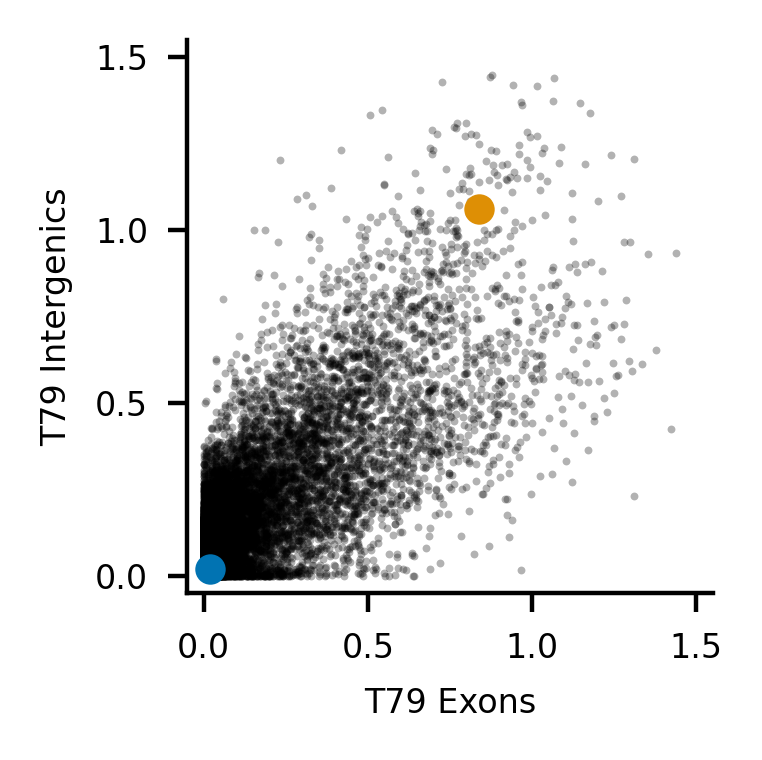

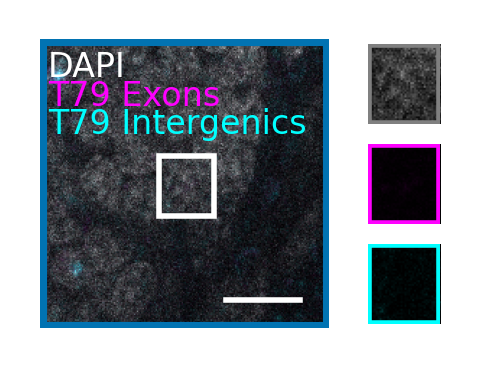

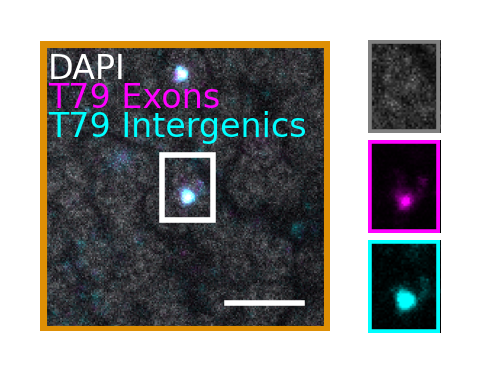

In [438]:
# T79-intergenic-b2-647 T79-exonic-b1-546 
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=None, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="T79 Exons", c2_name="T79 Intergenics",
                c1_color="magenta", c2_color="cyan",
                coordinates=[[0.02, 0.02], [0.9, 1]],
                dapi_max=200, c1_max=200, c2_max=200)

## Chymotrypsin (LOC105276652)

In [670]:
input = 'U34'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI as input directory


In [671]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [673]:
channels = ['AF546', 'AF647']
channel_names = ["U34", "LOC105276652"]
channel_colors = ["cyan", "yellow"]
channel_maxs = [255, 255]

In [674]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)

# Assign cytoplasmic annotations based on border pixels, nuclear area, normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > valence_OR_border_threshold) & (results['nucleus_area'] > valence_OR_nuc_norm_threshold) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)

manual_cytoplasmic_channels = results['cytoplasmic'].value_counts().index.tolist()
for channel in manual_cytoplasmic_channels: 
    num_cells = results[results['cytoplasmic'] == channel].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation: {num_cells}")
    num_cells_with_valence_OR = results[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'])].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation and valence OR annotation: {num_cells_with_valence_OR}")
    nuc_norm = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-nuc-norm"].mean()
    print(f"Missing cells mean {channel} nucleus normalized signal: {nuc_norm:.2f}")
    rel_cyto = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-cyto-norm"].mean()
    print(f"Missing cells mean {channel} cytoplasmic normalized signal: {rel_cyto:.2f}")


results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF546 cytoplasmic annotation: 60
Number of cells with AF546 cytoplasmic annotation and valence OR annotation: 58
Missing cells mean AF546 nucleus normalized signal: 1.00
Missing cells mean AF546 cytoplasmic normalized signal: 0.06
Number of cells with AF647 cytoplasmic annotation: 57
Number of cells with AF647 cytoplasmic annotation and valence OR annotation: 37
Missing cells mean AF647 nucleus normalized signal: 0.93
Missing cells mean AF647 cytoplasmic normalized signal: 0.16


image    z  z_id  border_pxls  nucleus_area  \
0    20250307 B1 Sample 1 Stack.czi   24     1          291         388.0   
1    20250307 B1 Sample 1 Stack.czi   24     2          298         732.0   
2    20250307 B1 Sample 1 Stack.czi   26     1          270         448.0   
3    20250307 B1 Sample 1 Stack.czi   78   125          228         685.0   
4    20250307 B1 Sample 1 Stack.czi   79   124          219         754.0   
..                              ...  ...   ...          ...           ...   
713  20250307 B1 Sample 4 Stack.czi  158   154          301        1004.0   
714  20250307 B1 Sample 4 Stack.czi  159   144          321        1045.0   
715  20250307 B1 Sample 4 Stack.czi  159   243          253         682.0   
716  20250307 B1 Sample 4 Stack.czi  168    14          221         788.0   
717  20250307 B1 Sample 4 Stack.czi  169    11          210         865.0   

    channel  cyto-norm cytoplasmic_channel  nuc-norm  channel_name  \
0     AF546   1.109211               AF546  1.200030           U34   
1     AF546   0.668089               AF546  0.891906           U34   
2     AF546   0.461885               AF546  0.867515           U34   
3     AF546   0.434288               AF546  0.899022           U34   
4     AF546   0.501985               AF546  1.105218           U34   
..      ...        ...                 ...       ...           ...   
713   AF647   0.418996               AF647  1.229138  LOC105276652   
714   AF647   0.418327               AF647  0.752243  LOC105276652   
715   AF647   0.389844               AF647  0.810937  LOC105276652   
716   AF647   0.208331               AF647  0.754739  LOC105276652   
717   AF647   0.251966               AF647  0.810971  LOC105276652   

             valence_OR_name  
0             U34 valence OR  
1             U34 valence OR  
2             U34 valence OR  
3             U34 valence OR  
4             U34 valence OR  
..                       ...  
713  LOC105276652 valence OR  
714  LOC105276652 valence OR  
715  LOC105276652 valence OR  
716  LOC105276652 valence OR  
717  LOC105276652 valence OR  

[1476 rows x 11 columns]

<Axes: >

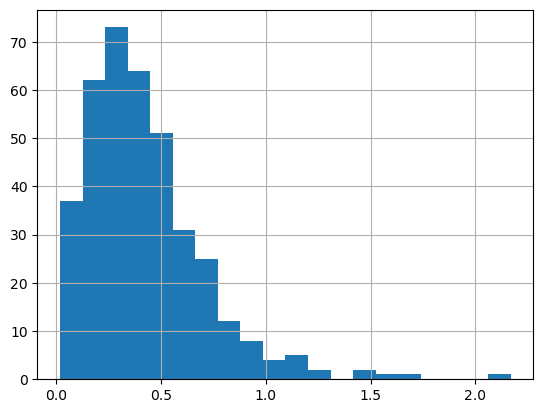

In [675]:
results_melted.loc[(results_melted['valence_OR_name'] == "U34 valence OR") & 
                   (results_melted['channel_name'] == "LOC105276652")]['nuc-norm'].hist(bins=20)

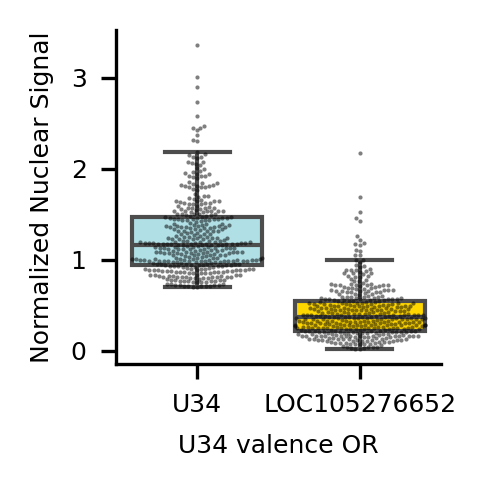

In [676]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
plot_colors = ['powderblue', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

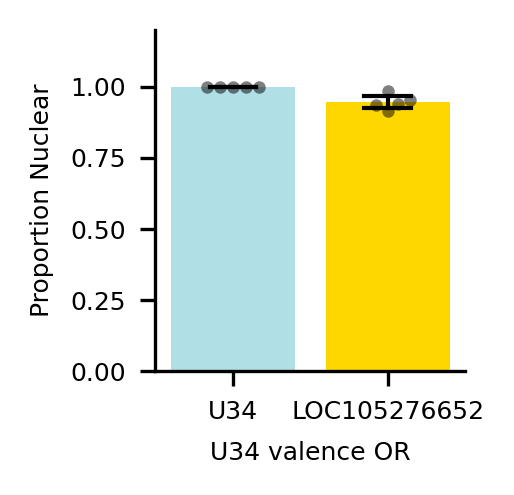

In [677]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
plot_colors = ['powderblue', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

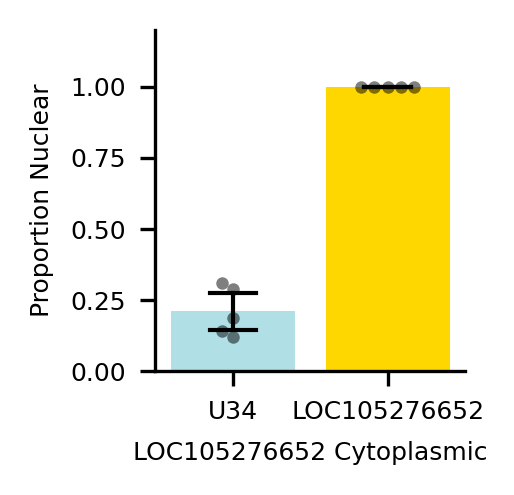

In [678]:
valence_channel = "LOC105276652 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
plot_colors = ['powderblue', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"LOC105276652 Cytoplasmic", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

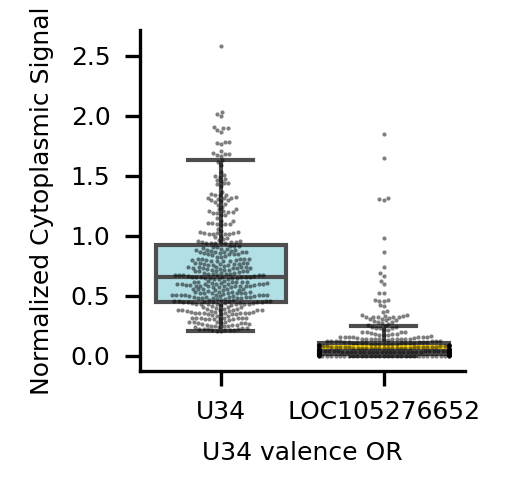

In [679]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
plot_colors = ['powderblue', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

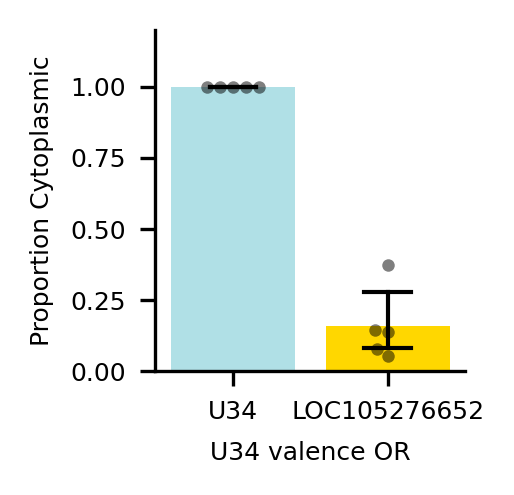

In [680]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
plot_colors = ['powderblue', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

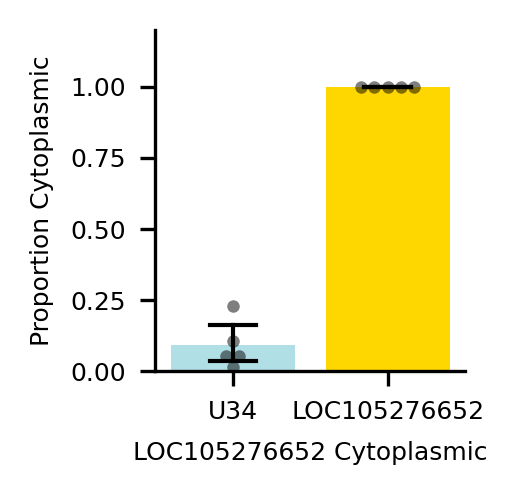

In [681]:
valence_channel = "LOC105276652 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
plot_colors = ['powderblue', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"LOC105276652 Cytoplasmic", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

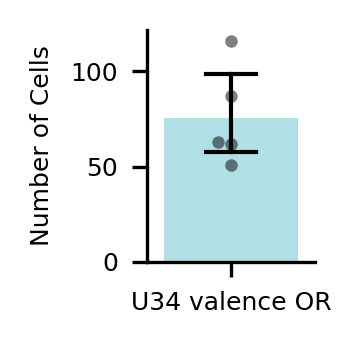

In [682]:
# Plot the number of cells 
valence_channel = "U34 valence OR"
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('cytoplasmic', '\ncytoplasmic')
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25), dpi = 300) 
valence_counts_subset = valence_counts[valence_counts["valence_OR_name"] == valence_channel]
sns.barplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [683]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 0.5, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 202, 3, 2048, 2048)
Loaded ../results/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack_rois.npy
Loaded ../results/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack_cell_borders.npy


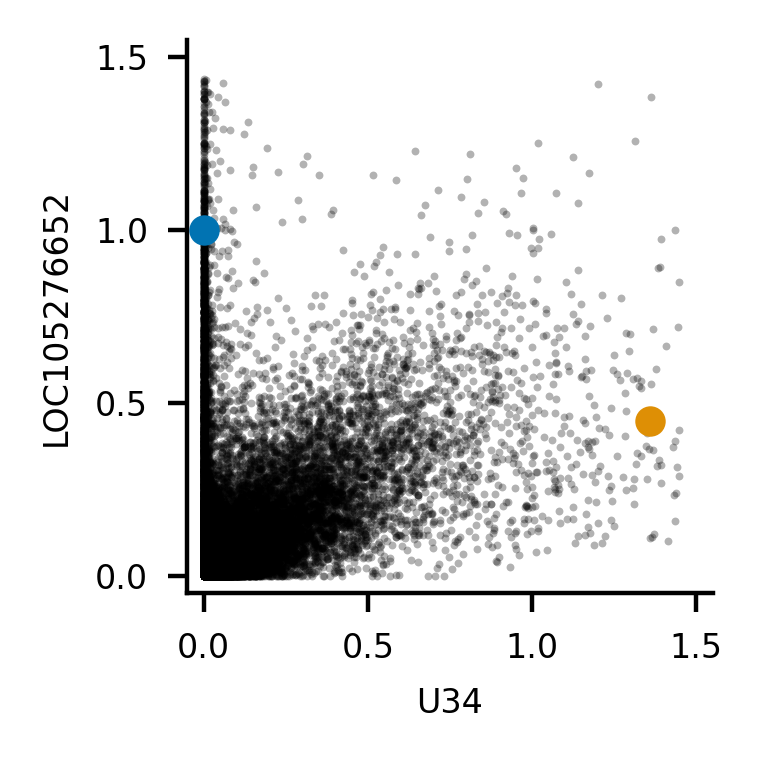

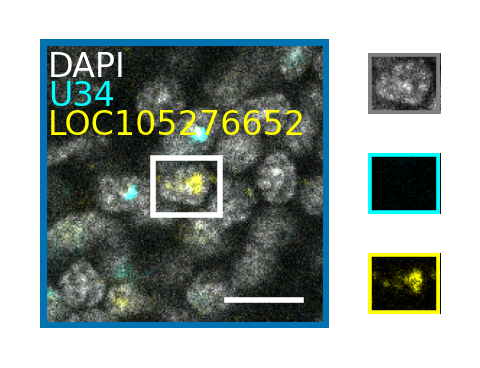

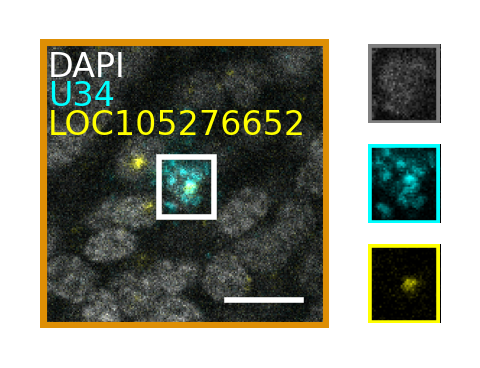

In [684]:
# U34-B3-546 Chymotrypsin-B2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="U34", c2_name="LOC105276652",
                c1_color="cyan", c2_color="yellow",
                coordinates=[[0, 1], [1.4, 0.5]],
                dapi_max=200, c1_max=100, c2_max=150)

## U34, U21, PR

In [567]:
input = 'u21'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi as input directory


In [568]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [569]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [570]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)

# Assign cytoplasmic annotations based on border pixels, nuclear area, normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > valence_OR_border_threshold) & (results['nucleus_area'] > valence_OR_nuc_norm_threshold) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)

manual_cytoplasmic_channels = results['cytoplasmic'].value_counts().index.tolist()
for channel in manual_cytoplasmic_channels: 
    num_cells = results[results['cytoplasmic'] == channel].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation: {num_cells}")
    num_cells_with_valence_OR = results[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'])].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation and valence OR annotation: {num_cells_with_valence_OR}")
    nuc_norm = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-nuc-norm"].mean()
    print(f"Missing cells mean {channel} nucleus normalized signal: {nuc_norm:.2f}")
    rel_cyto = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-cyto-norm"].mean()
    print(f"Missing cells mean {channel} cytoplasmic normalized signal: {rel_cyto:.2f}")


results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF647 cytoplasmic annotation: 84
Number of cells with AF647 cytoplasmic annotation and valence OR annotation: 51
Missing cells mean AF647 nucleus normalized signal: 0.68
Missing cells mean AF647 cytoplasmic normalized signal: 0.15
Number of cells with AF488 cytoplasmic annotation: 46
Number of cells with AF488 cytoplasmic annotation and valence OR annotation: 41
Missing cells mean AF488 nucleus normalized signal: 0.80
Missing cells mean AF488 cytoplasmic normalized signal: 0.07


image   z  z_id  border_pxls  \
0    20250325 4 t19 lncrna sample 1 great.czi  10   182          124   
1    20250325 4 t19 lncrna sample 1 great.czi  10   282          131   
2    20250325 4 t19 lncrna sample 1 great.czi  11   200          234   
3    20250325 4 t19 lncrna sample 1 great.czi  12   133          299   
4    20250325 4 t19 lncrna sample 1 great.czi  12   188          204   
..                                        ...  ..   ...          ...   
796  20250325 4 t19 lncrna sample 4 great.czi  69   286          157   
797  20250325 4 t19 lncrna sample 4 great.czi  72   141          214   
798  20250325 4 t19 lncrna sample 4 great.czi  74    78          237   
799  20250325 4 t19 lncrna sample 4 great.czi  75    62          292   
800  20250325 4 t19 lncrna sample 4 great.czi  76    48          304   

     nucleus_area channel  cyto-norm cytoplasmic_channel  nuc-norm  \
0           322.0   AF488   1.189690               AF488  1.224413   
1           564.0   AF488   0.287343               AF488  0.723285   
2           719.0   AF488   0.746509               AF488  1.381559   
3           845.0   AF488   0.968210               AF488  1.234904   
4           821.0   AF488   1.061252               AF488  1.096221   
..            ...     ...        ...                 ...       ...   
796         291.0   AF647   0.742148               AF647  1.077976   
797         473.0   AF647   0.280594               AF647  0.776918   
798         755.0   AF647   0.425548               AF647  1.026747   
799         889.0   AF647   0.369528               AF647  1.208388   
800         798.0   AF647   0.497539               AF647  1.013822   

    channel_name valence_OR_name  
0            U34  U34 valence OR  
1            U34  U34 valence OR  
2            U34  U34 valence OR  
3            U34  U34 valence OR  
4            U34  U34 valence OR  
..           ...             ...  
796          U21  U21 valence OR  
797          U21  U21 valence OR  
798          U21  U21 valence OR  
799          U21  U21 valence OR  
800          U21  U21 valence OR  

[1497 rows x 11 columns]

<Axes: >

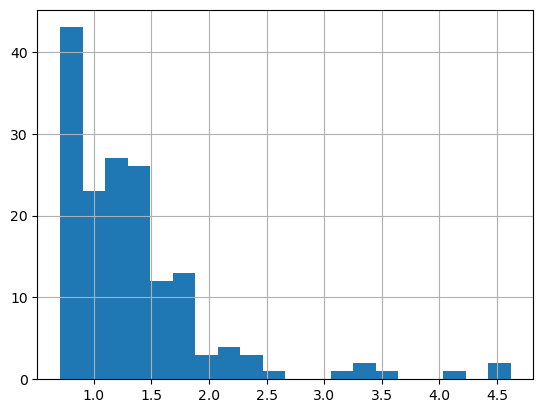

In [571]:
results_melted.loc[(results_melted['valence_OR_name'] == "U34 valence OR") & 
                   (results_melted['channel_name'] == "U34")]['nuc-norm'].hist(bins=20)

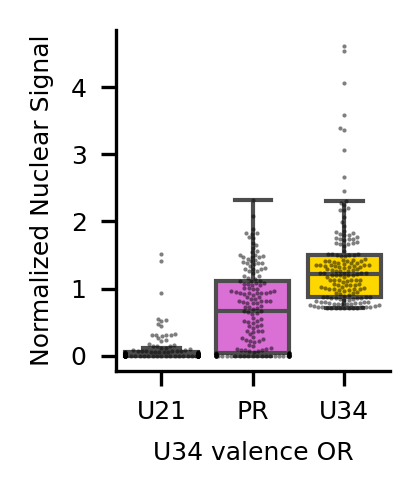

In [572]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

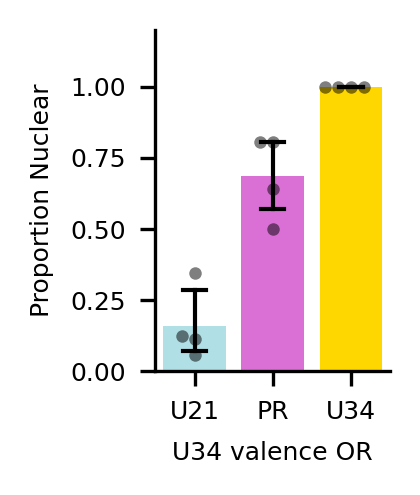

In [573]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

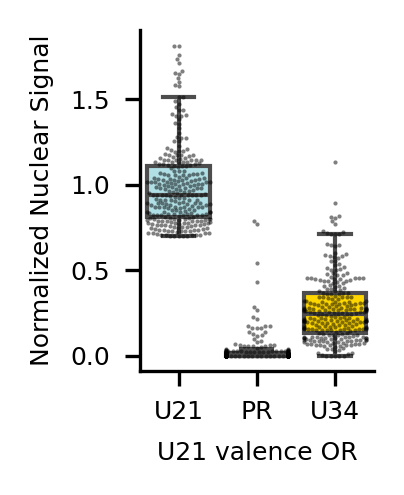

In [574]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

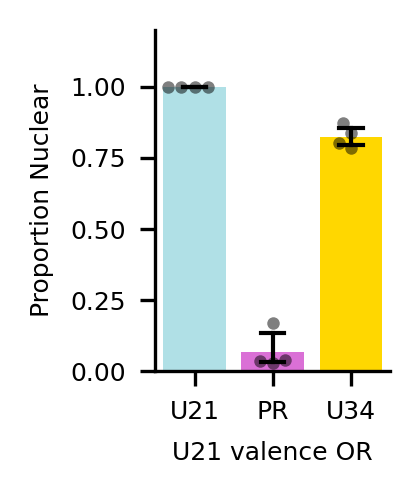

In [575]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors = ['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

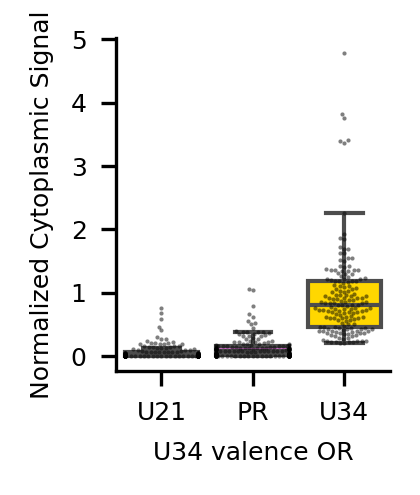

In [576]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

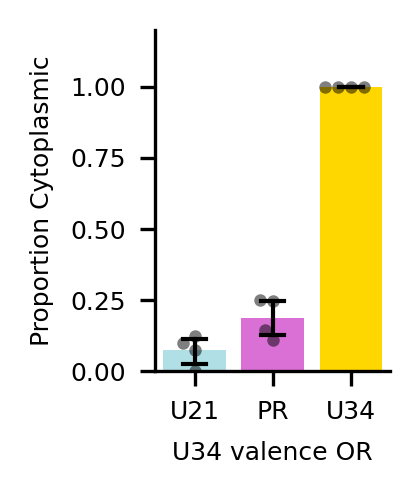

In [577]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

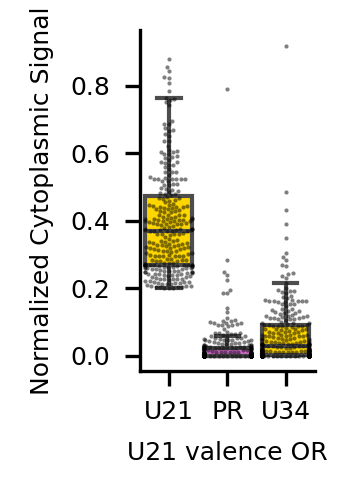

In [578]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=['gold', 'orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

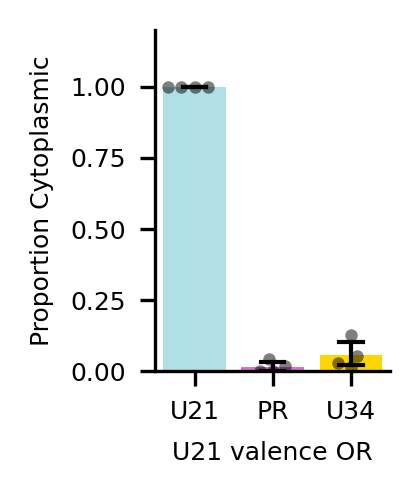

In [579]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

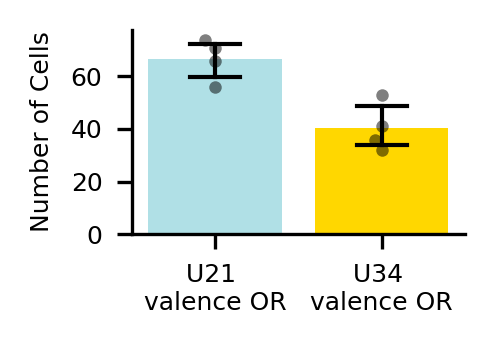

In [580]:
# Plot the number of cells 
valence_ORs = ["U34 valence OR", "U21 valence OR"]
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts = valence_counts[valence_counts["valence_OR_name"].isin(valence_ORs)]
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.25), dpi = 300) 
sns.barplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue', 'gold'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [467]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 4 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 30779.721115112305, 26878.52767944336), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 80, 4, 2048, 2048)
Loaded ../results/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 4 great_rois.npy
Loaded ../results/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 4 great_cell_borders.npy


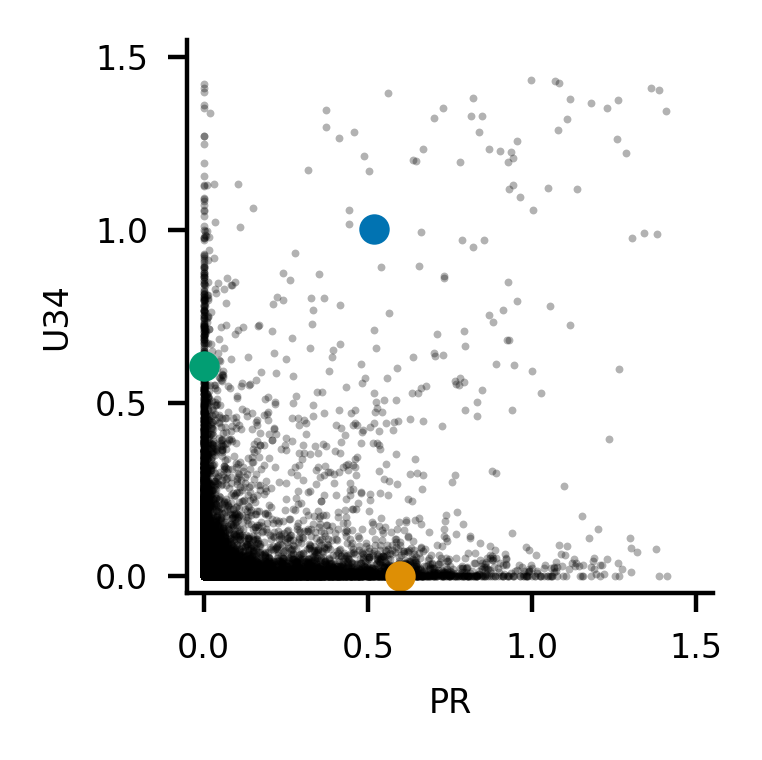

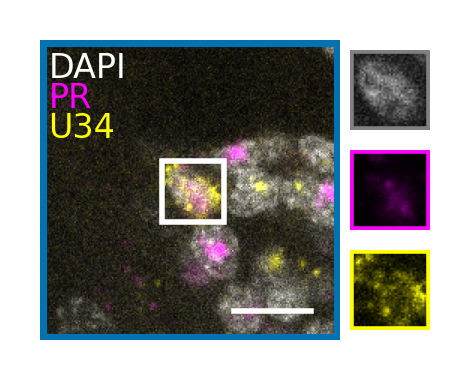

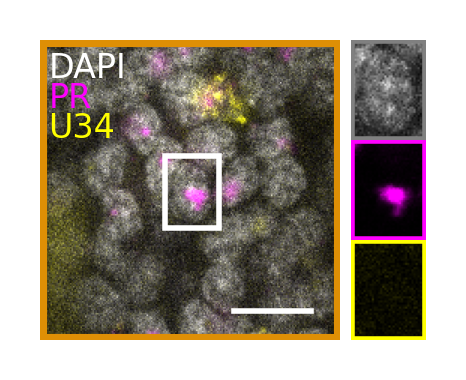

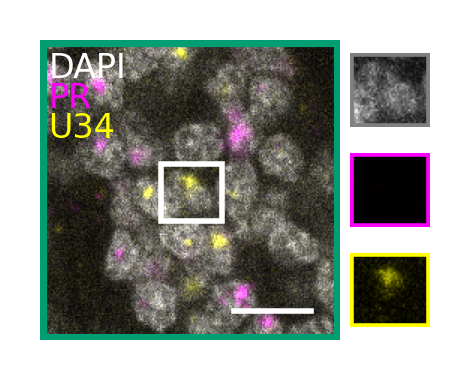

In [468]:
# u34-b3-488 lnc4-b1-546 u21-b5-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF488-nuc-norm", 
                c1_name="PR", c2_name="U34",
                c1_color="magenta", c2_color="yellow",
                coordinates=[[0.5, 1], [0.6, 0], [0, 0.6]],
                dapi_max=200, c1_max=200, c2_max=150)

## L16 & PR

In [596]:
input = 'L16'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI as input directory


In [597]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [605]:
channels = ['AF594', 'AF647']
channel_names = ["L16", "PR"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [606]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)

# Assign cytoplasmic annotations based on border pixels, nuclear area, normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > valence_OR_border_threshold) & (results['nucleus_area'] > valence_OR_nuc_norm_threshold) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)

manual_cytoplasmic_channels = results['cytoplasmic'].value_counts().index.tolist()
for channel in manual_cytoplasmic_channels: 
    num_cells = results[results['cytoplasmic'] == channel].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation: {num_cells}")
    num_cells_with_valence_OR = results[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'])].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation and valence OR annotation: {num_cells_with_valence_OR}")
    nuc_norm = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-nuc-norm"].mean()
    print(f"Missing cells mean {channel} nucleus normalized signal: {nuc_norm:.2f}")
    rel_cyto = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-cyto-norm"].mean()
    print(f"Missing cells mean {channel} cytoplasmic normalized signal: {rel_cyto:.2f}")


results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF594 cytoplasmic annotation: 267
Number of cells with AF594 cytoplasmic annotation and valence OR annotation: 131
Missing cells mean AF594 nucleus normalized signal: 0.51
Missing cells mean AF594 cytoplasmic normalized signal: 0.42


image   z  z_id  border_pxls  nucleus_area  \
0    20250328 3 L16lnc sample 4.czi  17    44          238         635.0   
1    20250328 3 L16lnc sample 4.czi  17    60          272         669.0   
2    20250328 3 L16lnc sample 4.czi  45   355          145         316.0   
3    20250328 3 L16lnc sample 4.czi  46   388          228         477.0   
4    20250328 3 L16lnc sample 4.czi  47   297          225         446.0   
..                              ...  ..   ...          ...           ...   
247  20250328 3 L16lnc sample 1.czi  71   183          213         417.0   
248  20250328 3 L16lnc sample 1.czi  72   134          220         540.0   
249  20250328 3 L16lnc sample 1.czi  73   125          268         751.0   
250  20250328 3 L16lnc sample 1.czi  73   210          154         597.0   
251  20250328 3 L16lnc sample 1.czi  74   172          209         361.0   

    channel  cyto-norm cytoplasmic_channel  nuc-norm channel_name  \
0     AF594   0.500997               AF594  0.904739          L16   
1     AF594   0.420756               AF594  0.721947          L16   
2     AF594   0.663335               AF594  0.749285          L16   
3     AF594   0.611356               AF594  0.751703          L16   
4     AF594   1.008477               AF594  0.817358          L16   
..      ...        ...                 ...       ...          ...   
247   AF647   0.592784               AF647  0.796603           PR   
248   AF647   0.578674               AF647  1.890453           PR   
249   AF647   0.349817               AF647  0.769743           PR   
250   AF647   0.722991               AF647  1.021676           PR   
251   AF647   0.632412               AF647  0.836705           PR   

    valence_OR_name  
0    L16 valence OR  
1    L16 valence OR  
2    L16 valence OR  
3    L16 valence OR  
4    L16 valence OR  
..              ...  
247   PR valence OR  
248   PR valence OR  
249   PR valence OR  
250   PR valence OR  
251   PR valence OR  

[952 rows x 11 columns]

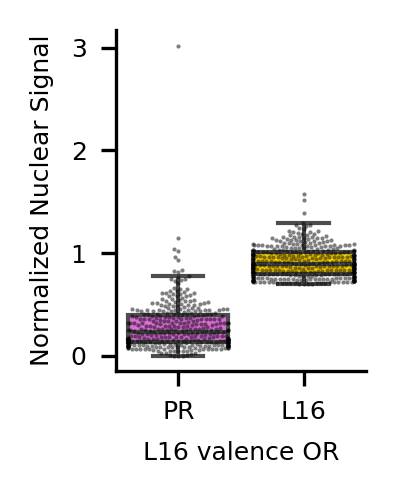

In [607]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-mean-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

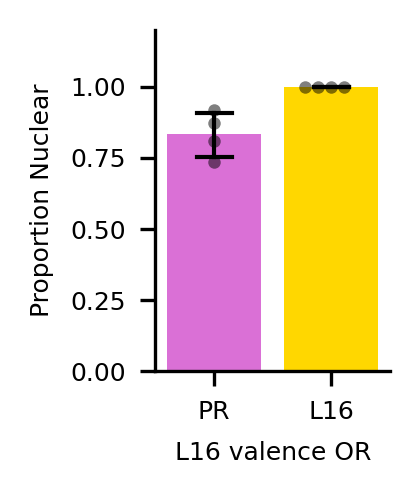

In [608]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=['orchid', 'gold'], order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

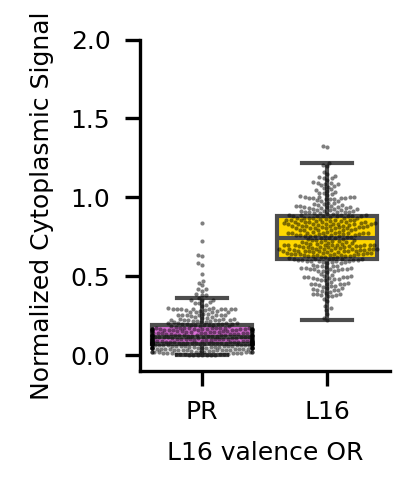

In [609]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=['orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 2)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

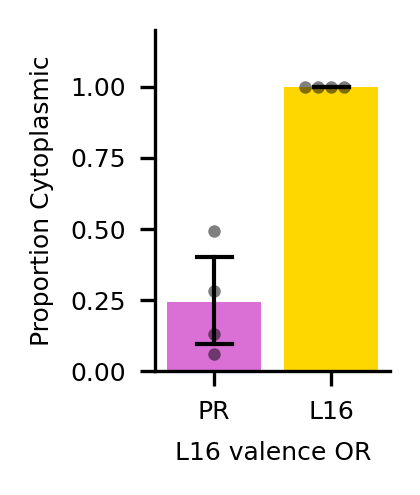

In [610]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
plot_colors = ['orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

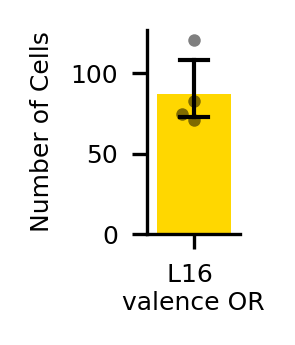

In [611]:
# Plot the number of cells 
valence_channel = "L16 \nvalence OR"
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1, 1.25), dpi = 300) 
valence_counts_subset = valence_counts[valence_counts["valence_OR_name"] == valence_channel]
sns.barplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, palette=['gold'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [612]:
file_number = 2
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF488-T1', 'AF647-T1', 'DAPI-T2', 'AF594-T2']}
Image shape: (1, 81, 4, 2048, 2048)
Loaded ../results/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3_rois.npy
Loaded ../results/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3_cell_borders.npy


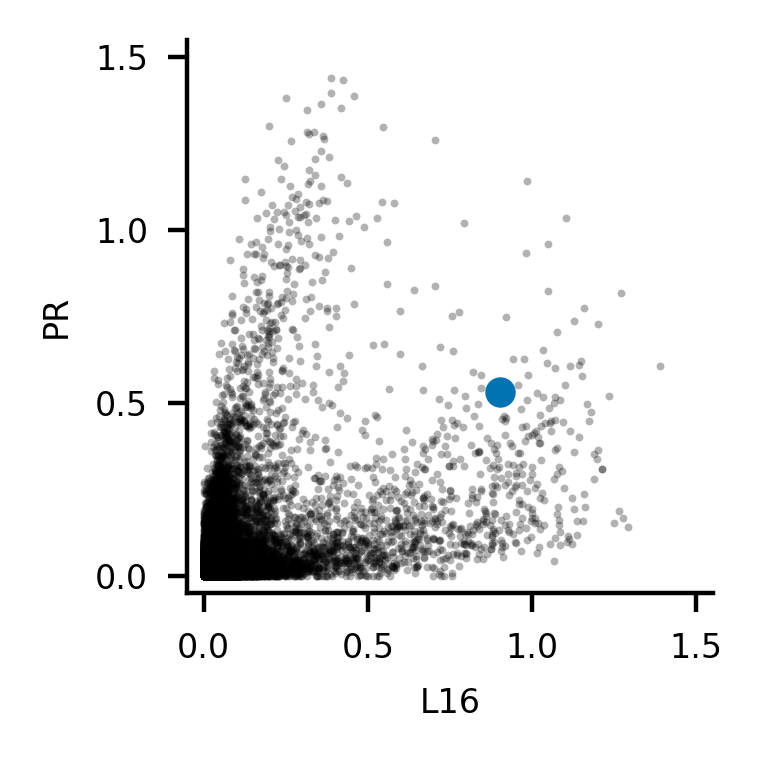

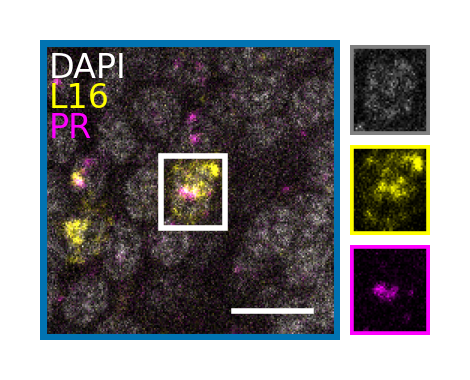

In [613]:
# Lnc3-b3-488 L16-b2-594 Lnc2-b5-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF594-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="L16", c2_name="PR",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[0.9, 0.5]], bbox_expansion=7,
                dapi_max=100, c1_max=150, c2_max=100)

## G1

In [614]:
input = 'g1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi as input directory


In [615]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [616]:
channels = ['AF546', 'AF647']
channel_names = ["G1", "LOC113562161"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [617]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)

# Assign cytoplasmic annotations based on border pixels, nuclear area, normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > valence_OR_border_threshold) & (results['nucleus_area'] > valence_OR_nuc_norm_threshold) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)

manual_cytoplasmic_channels = results['cytoplasmic'].value_counts().index.tolist()
for channel in manual_cytoplasmic_channels: 
    num_cells = results[results['cytoplasmic'] == channel].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation: {num_cells}")
    num_cells_with_valence_OR = results[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'])].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation and valence OR annotation: {num_cells_with_valence_OR}")
    nuc_norm = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-nuc-norm"].mean()
    print(f"Missing cells mean {channel} nucleus normalized signal: {nuc_norm:.2f}")
    rel_cyto = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-cyto-norm"].mean()
    print(f"Missing cells mean {channel} cytoplasmic normalized signal: {rel_cyto:.2f}")


results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF546 cytoplasmic annotation: 61
Number of cells with AF546 cytoplasmic annotation and valence OR annotation: 42
Missing cells mean AF546 nucleus normalized signal: 1.12
Missing cells mean AF546 cytoplasmic normalized signal: 0.13


image   z  z_id  border_pxls  \
0    20250325 5 G1 lncrna sample 4 great.czi   7   188          191   
1    20250325 5 G1 lncrna sample 4 great.czi   7   273          253   
2    20250325 5 G1 lncrna sample 4 great.czi   8    37          231   
3    20250325 5 G1 lncrna sample 4 great.czi  10   208          306   
4    20250325 5 G1 lncrna sample 4 great.czi  19   170          201   
..                                       ...  ..   ...          ...   
175  20250325 5 G1 lncrna sample 3 great.czi  66   142          264   
176  20250325 5 G1 lncrna sample 3 great.czi  66   274          315   
177  20250325 5 G1 lncrna sample 3 great.czi  67   126          264   
178  20250325 5 G1 lncrna sample 3 great.czi  67   256          245   
179  20250325 5 G1 lncrna sample 3 great.czi  68     2          271   

     nucleus_area channel  cyto-norm cytoplasmic_channel  nuc-norm  \
0           899.0   AF546   0.361131               AF546  0.826887   
1           895.0   AF546   0.234534               AF546  1.377356   
2           763.0   AF546   0.218620               AF546  1.362877   
3           874.0   AF546   0.213896               AF546  1.126937   
4           374.0   AF546   0.858041               AF546  0.901148   
..            ...     ...        ...                 ...       ...   
175         802.0   AF647   0.521033               AF647  3.325529   
176         906.0   AF647   0.439463               AF647  3.024624   
177         669.0   AF647   0.824286               AF647  2.184043   
178         534.0   AF647   1.087857               AF647  2.769336   
179         767.0   AF647   0.405361               AF647  2.399136   

     channel_name          valence_OR_name  
0              G1            G1 valence OR  
1              G1            G1 valence OR  
2              G1            G1 valence OR  
3              G1            G1 valence OR  
4              G1            G1 valence OR  
..            ...                      ...  
175  LOC113562161  LOC113562161 valence OR  
176  LOC113562161  LOC113562161 valence OR  
177  LOC113562161  LOC113562161 valence OR  
178  LOC113562161  LOC113562161 valence OR  
179  LOC113562161  LOC113562161 valence OR  

[406 rows x 11 columns]

In [618]:
# Pearson correlation of AF546-nuc-norm and AF647-nuc-norm
from scipy.stats import pearsonr
r, p = pearsonr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Pearson correlation coefficient: {r}, p-value: {p}")

Pearson correlation coefficient: 0.8762373723504546, p-value: 0.0


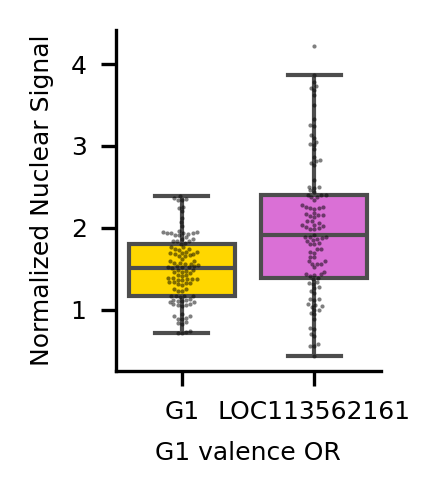

In [620]:
valence_channel = "G1 valence OR"
channels_to_plot = ["G1", "LOC113562161"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['gold', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-mean-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

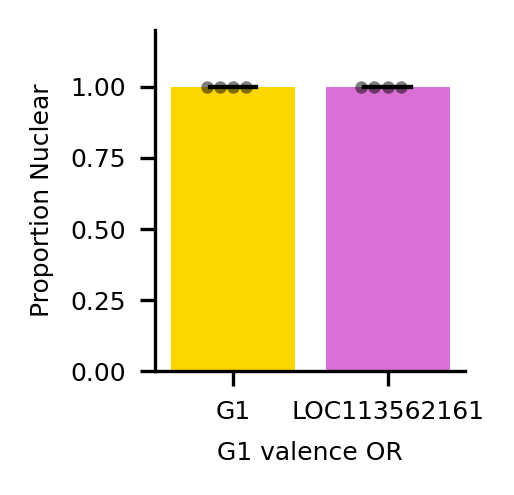

In [621]:
valence_channel = "G1 valence OR"
channels_to_plot = ["G1", "LOC113562161"]
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=['gold', 'orchid'], order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

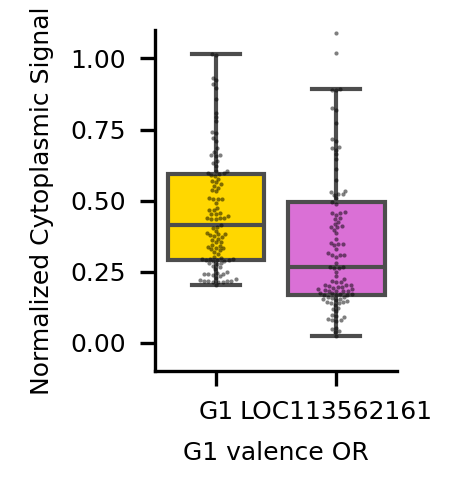

In [622]:
valence_channel = "G1 valence OR"
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel)]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=['gold', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

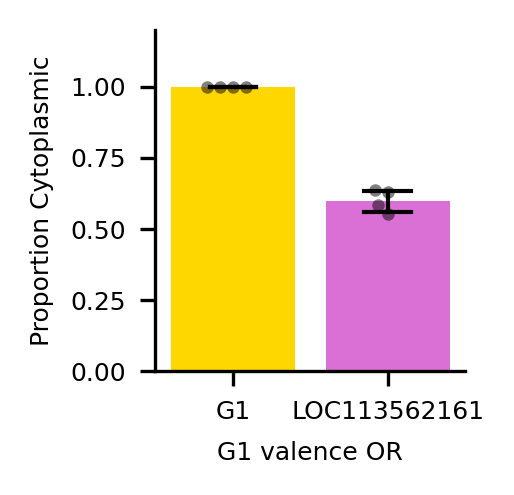

In [623]:
valence_channel = "G1 valence OR"
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel)]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=['gold', 'orchid'], order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

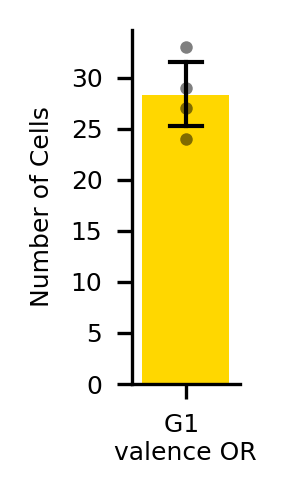

In [624]:
# Plot the number of cells 
valence_channel = "G1 \nvalence OR"
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1, 1.75), dpi = 300) 
valence_counts_subset = valence_counts[valence_counts["valence_OR_name"] == valence_channel]
sns.barplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, palette=['gold'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [625]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi/20250325 5 G1 lncrna sample 2 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 78, 3, 2048, 2048)
Loaded ../results/20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi/20250325 5 G1 lncrna sample 2 great_rois.npy
Loaded ../results/20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi/20250325 5 G1 lncrna sample 2 great_cell_borders.npy


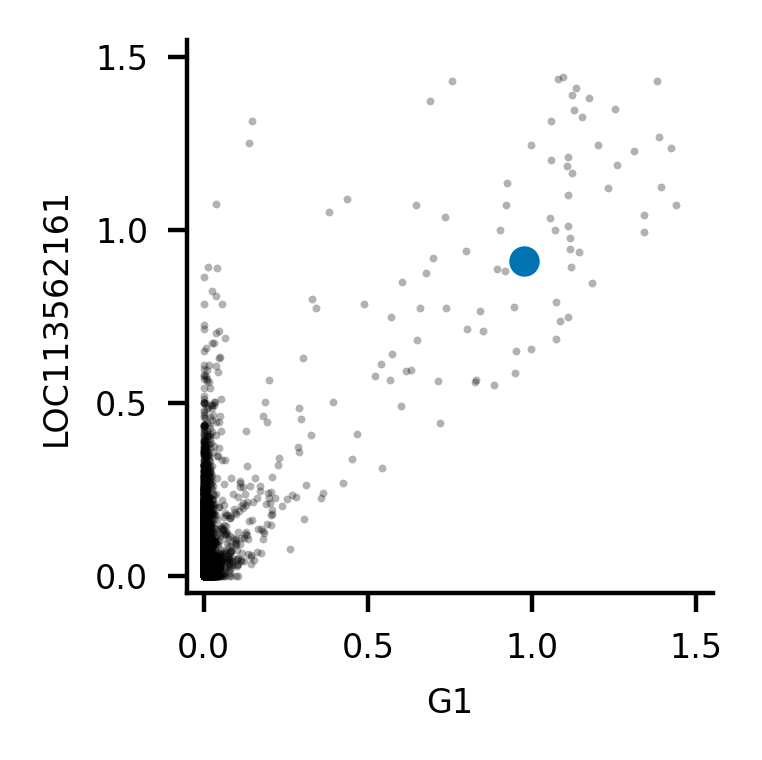

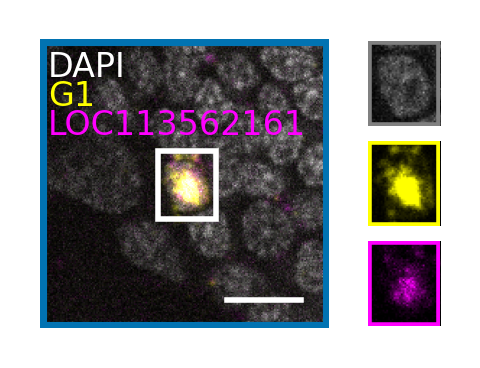

In [626]:
# g1-b1-546 lnc7-b2-647
plot_2_channels(results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="G1", c2_name="LOC113562161",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[1, 1]],
                dapi_max=200, c1_max=100, c2_max=100)

## Q1, R2, PR

In [627]:
input = 'Q1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI as input directory


In [628]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [629]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["R2-3", "Q1", "PR"]
channel_colors = ["cyan", "yellow", "magenta"]
channel_maxs = [255, 255, 255]

In [630]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)

# Assign cytoplasmic annotations based on border pixels, nuclear area, normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > valence_OR_border_threshold) & (results['nucleus_area'] > valence_OR_nuc_norm_threshold) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)

manual_cytoplasmic_channels = results['cytoplasmic'].value_counts().index.tolist()
for channel in manual_cytoplasmic_channels: 
    num_cells = results[results['cytoplasmic'] == channel].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation: {num_cells}")
    num_cells_with_valence_OR = results[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'])].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation and valence OR annotation: {num_cells_with_valence_OR}")
    nuc_norm = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-nuc-norm"].mean()
    print(f"Missing cells mean {channel} nucleus normalized signal: {nuc_norm:.2f}")
    rel_cyto = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-cyto-norm"].mean()
    print(f"Missing cells mean {channel} cytoplasmic normalized signal: {rel_cyto:.2f}")


results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF546 cytoplasmic annotation: 216
Number of cells with AF546 cytoplasmic annotation and valence OR annotation: 164
Missing cells mean AF546 nucleus normalized signal: 0.60
Missing cells mean AF546 cytoplasmic normalized signal: 0.60
Number of cells with AF488 cytoplasmic annotation: 176
Number of cells with AF488 cytoplasmic annotation and valence OR annotation: 138
Missing cells mean AF488 nucleus normalized signal: 0.58
Missing cells mean AF488 cytoplasmic normalized signal: 0.25


image   z  z_id  border_pxls  nucleus_area  \
0    20250328 2 Q1lnc sample 2.czi   2     1          189         211.0   
1    20250328 2 Q1lnc sample 2.czi  15    99          195         708.0   
2    20250328 2 Q1lnc sample 2.czi  16   144          234         637.0   
3    20250328 2 Q1lnc sample 2.czi  19    47          221         496.0   
4    20250328 2 Q1lnc sample 2.czi  19   184          177         591.0   
..                             ...  ..   ...          ...           ...   
580  20250328 2 Q1lnc sample 4.czi  88   227          124         528.0   
581  20250328 2 Q1lnc sample 4.czi  89    77          294         805.0   
582  20250328 2 Q1lnc sample 4.czi  90    79          168         439.0   
583  20250328 2 Q1lnc sample 4.czi  93    85          270         747.0   
584  20250328 2 Q1lnc sample 4.czi  94    49          249         683.0   

    channel  cyto-norm cytoplasmic_channel  nuc-norm channel_name  \
0     AF488   1.729058               AF488  0.834798         R2-3   
1     AF488   0.273541               AF488  0.922558         R2-3   
2     AF488   0.227639               AF488  0.792356         R2-3   
3     AF488   0.391316               AF488  0.939186         R2-3   
4     AF488   0.375566               AF488  0.751080         R2-3   
..      ...        ...                 ...       ...          ...   
580   AF647   1.147418               AF647  1.566045           PR   
581   AF647   0.334002               AF647  2.111895           PR   
582   AF647   0.836492               AF647  2.040625           PR   
583   AF647   0.353115               AF647  2.220585           PR   
584   AF647   0.912155               AF647  2.057133           PR   

     valence_OR_name  
0    R2-3 valence OR  
1    R2-3 valence OR  
2    R2-3 valence OR  
3    R2-3 valence OR  
4    R2-3 valence OR  
..               ...  
580    PR valence OR  
581    PR valence OR  
582    PR valence OR  
583    PR valence OR  
584    PR valence OR  

[3105 rows x 11 columns]

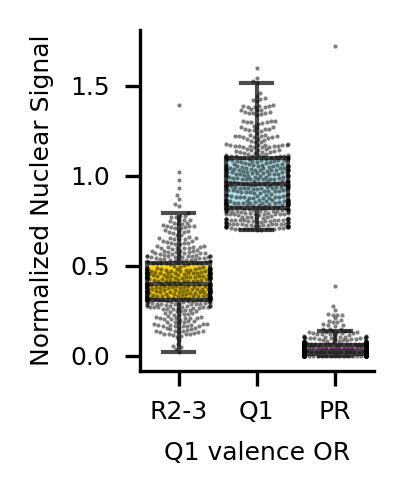

In [631]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

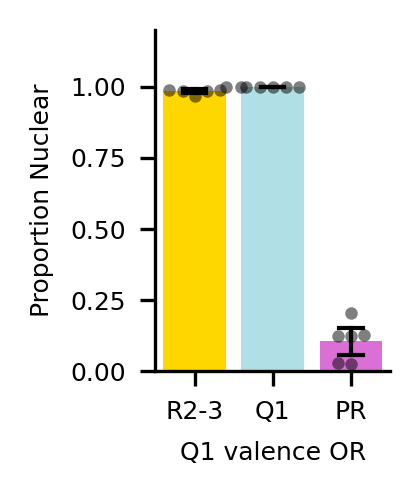

In [632]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

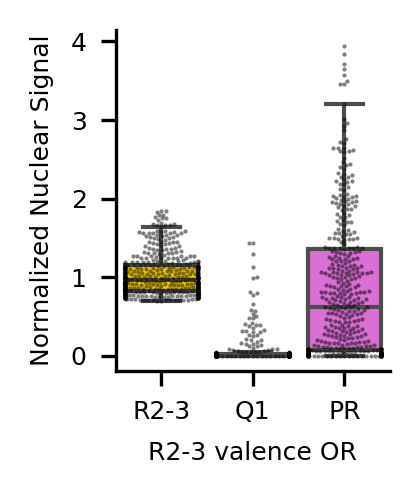

In [633]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

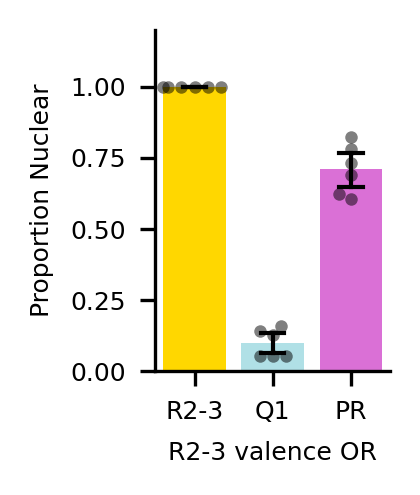

In [634]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

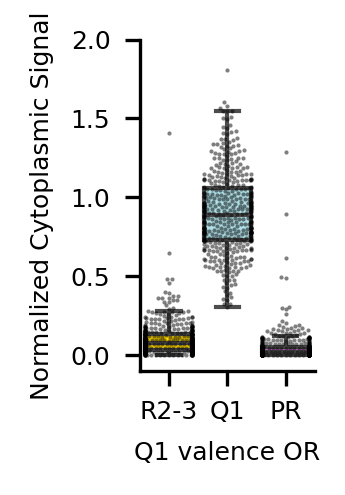

In [635]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 2)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

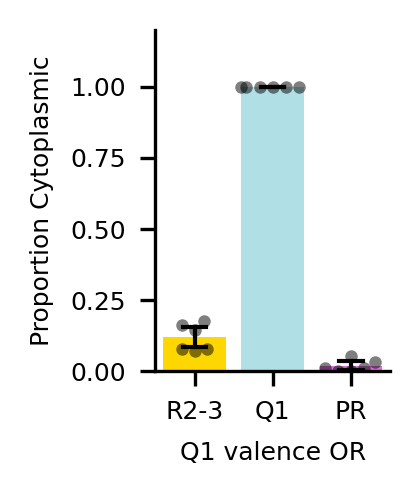

In [636]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

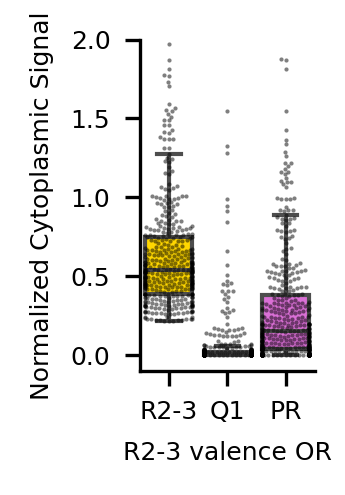

In [637]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 2)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-r2-cyto-pr-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

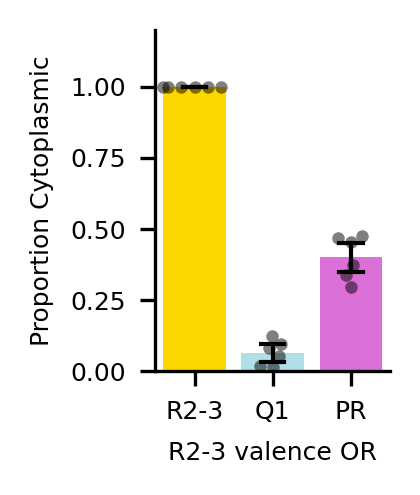

In [638]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'powderblue', 'orchid']
cyto_norm_threshold = 0.2
coexpression_nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

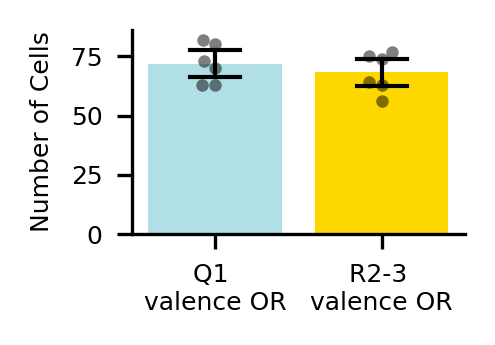

In [644]:
# Plot the number of cells 
valence_ORs = ['R2-3 valence OR', 'Q1 valence OR']
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts = valence_counts[valence_counts['valence_OR_name'].isin(valence_ORs)]
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.25), dpi = 300) 
sns.barplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue', 'gold'], saturation=1, order=['Q1 \nvalence OR', 'R2-3 \nvalence OR'],
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [645]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 103, 4, 2048, 2048)
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_rois.npy
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_cell_borders.npy


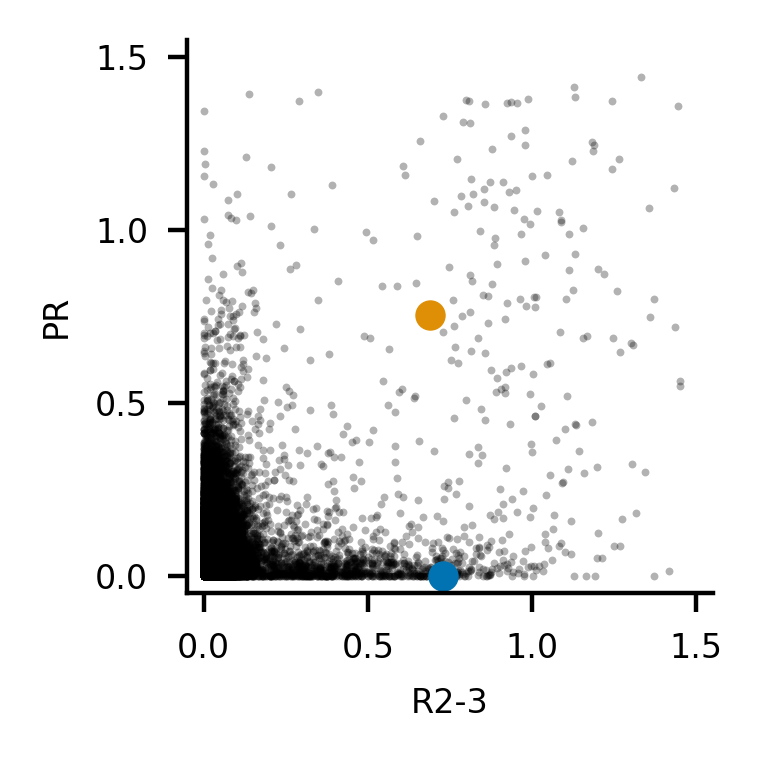

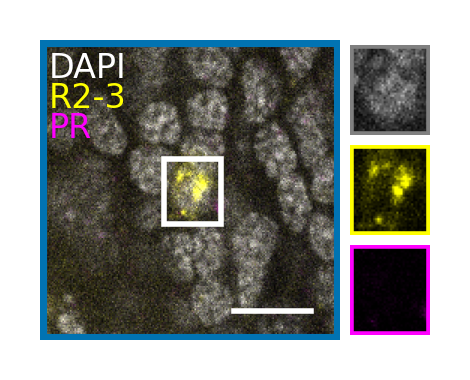

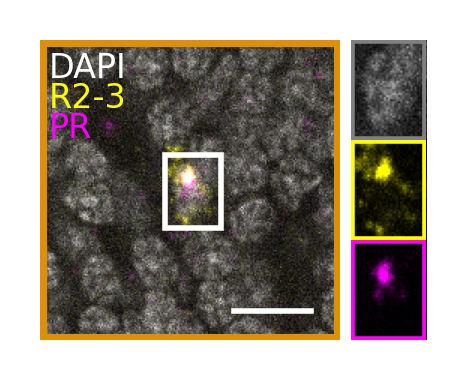

In [646]:
# R2-b3-488 Q1-b1-546 Lnc6-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="R2-3", c2_name="PR",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[0.75, 0], [0.7, 0.8]],
                dapi_max=255, c1_max=200, c2_max=200)

## 9E198

In [647]:
input = '9e198'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi as input directory


In [648]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [649]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E198", "9E197", "9E196"]
channel_colors = ["magenta", "cyan", "yellow"]
channel_maxs = [255, 255, 255]

In [650]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)

# Assign cytoplasmic annotations based on border pixels, nuclear area, normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > valence_OR_border_threshold) & (results['nucleus_area'] > valence_OR_nuc_norm_threshold) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)

manual_cytoplasmic_channels = results['cytoplasmic'].value_counts().index.tolist()
for channel in manual_cytoplasmic_channels: 
    num_cells = results[results['cytoplasmic'] == channel].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation: {num_cells}")
    num_cells_with_valence_OR = results[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'])].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation and valence OR annotation: {num_cells_with_valence_OR}")
    nuc_norm = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-nuc-norm"].mean()
    print(f"Missing cells mean {channel} nucleus normalized signal: {nuc_norm:.2f}")
    rel_cyto = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-cyto-norm"].mean()
    print(f"Missing cells mean {channel} cytoplasmic normalized signal: {rel_cyto:.2f}")


results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF647 cytoplasmic annotation: 81
Number of cells with AF647 cytoplasmic annotation and valence OR annotation: 76
Missing cells mean AF647 nucleus normalized signal: 0.64
Missing cells mean AF647 cytoplasmic normalized signal: 0.28
Number of cells with AF546 cytoplasmic annotation: 47
Number of cells with AF546 cytoplasmic annotation and valence OR annotation: 46
Missing cells mean AF546 nucleus normalized signal: 1.11
Missing cells mean AF546 cytoplasmic normalized signal: 0.20
Number of cells with AF488 cytoplasmic annotation: 44
Number of cells with AF488 cytoplasmic annotation and valence OR annotation: 38
Missing cells mean AF488 nucleus normalized signal: 0.85
Missing cells mean AF488 cytoplasmic normalized signal: 0.27


image   z  z_id  border_pxls  nucleus_area  \
0    20250325 5 t35 sample 4 great.czi  20   209          159         604.0   
1    20250325 5 t35 sample 4 great.czi  23   296          187         540.0   
2    20250325 5 t35 sample 4 great.czi  24   328          315         912.0   
3    20250325 5 t35 sample 4 great.czi  35   423          254         769.0   
4    20250325 5 t35 sample 4 great.czi  36   186          262         837.0   
..                                 ...  ..   ...          ...           ...   
556  20250325 5 t35 sample 1 great.czi  56    99          197         752.0   
557  20250325 5 t35 sample 1 great.czi  57    93          197         430.0   
558  20250325 5 t35 sample 1 great.czi  57   196          126         475.0   
559  20250325 5 t35 sample 1 great.czi  58   197          145         696.0   
560  20250325 5 t35 sample 1 great.czi  59   202          140         457.0   

    channel  cyto-norm cytoplasmic_channel  nuc-norm channel_name  \
0     AF488   0.254170               AF488  0.744836        9E198   
1     AF488   0.702128               AF488  0.798063        9E198   
2     AF488   0.329281               AF488  1.021218        9E198   
3     AF488   0.503720               AF488  0.919154        9E198   
4     AF488   0.297382               AF488  0.819126        9E198   
..      ...        ...                 ...       ...          ...   
556   AF647   0.461437               AF647  1.191049        9E196   
557   AF647   0.631103               AF647  1.420140        9E196   
558   AF647   0.813722               AF647  1.322363        9E196   
559   AF647   0.582592               AF647  1.314177        9E196   
560   AF647   0.840117               AF647  1.148337        9E196   

      valence_OR_name  
0    9E198 valence OR  
1    9E198 valence OR  
2    9E198 valence OR  
3    9E198 valence OR  
4    9E198 valence OR  
..                ...  
556  9E196 valence OR  
557  9E196 valence OR  
558  9E196 valence OR  
559  9E196 valence OR  
560  9E196 valence OR  

[1347 rows x 11 columns]

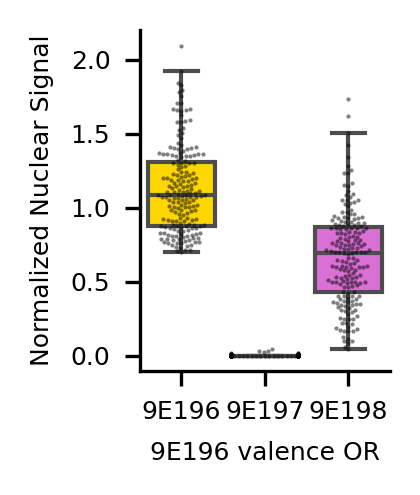

In [651]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

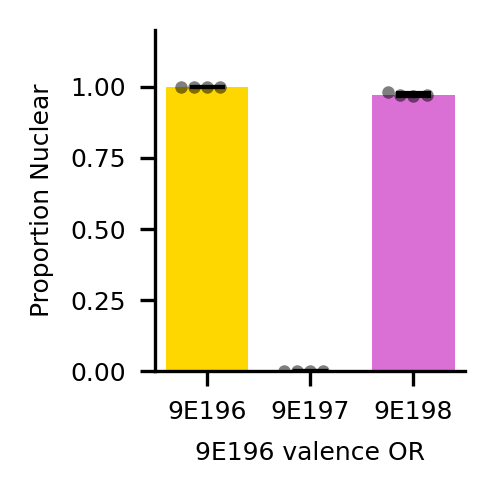

In [652]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

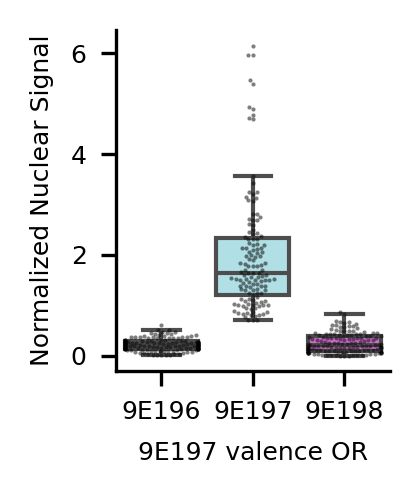

In [653]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

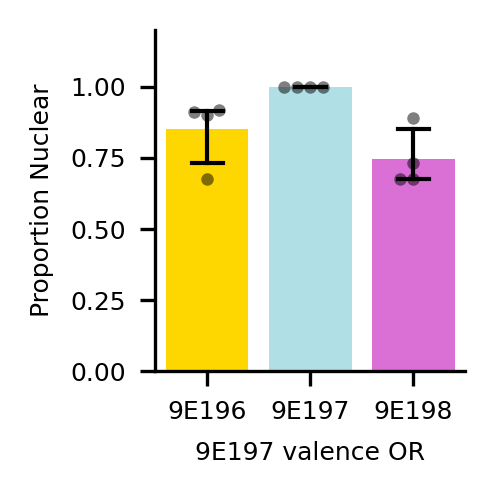

In [654]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

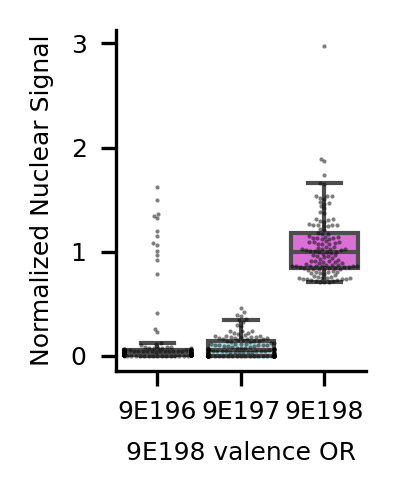

In [655]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

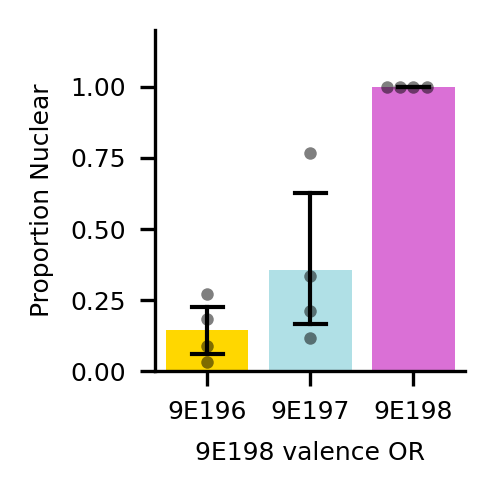

In [656]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

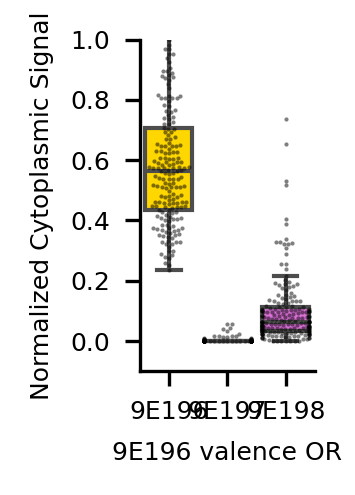

In [657]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

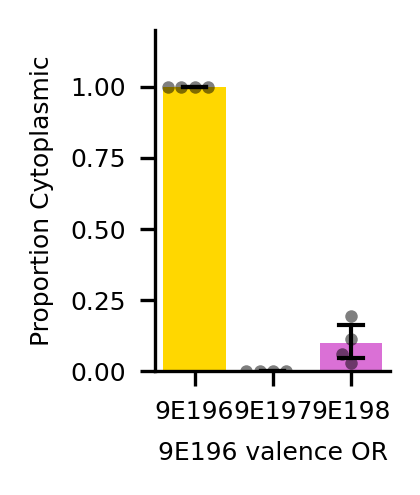

In [658]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
cyto_norm_threshold = 0.2 
coexpression_nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

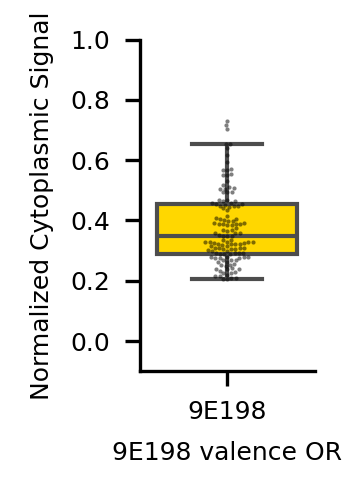

In [659]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E198"]
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=['gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

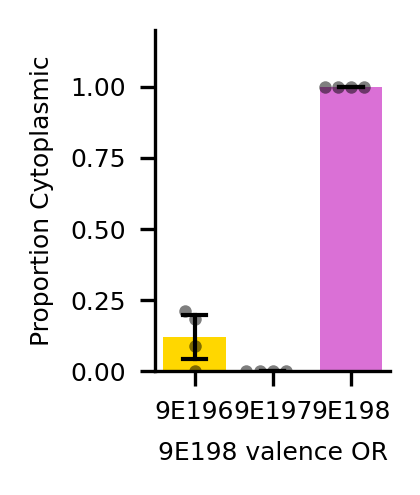

In [660]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
cyto_norm_threshold = 0.2 
coexpression_nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

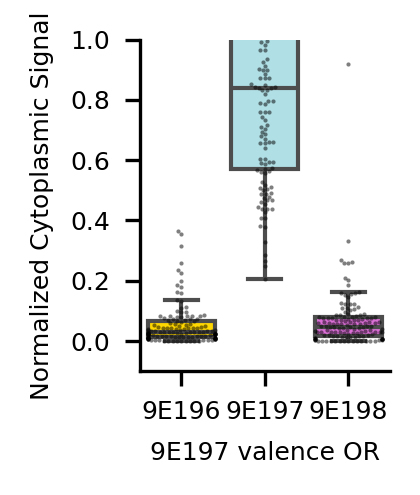

In [661]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

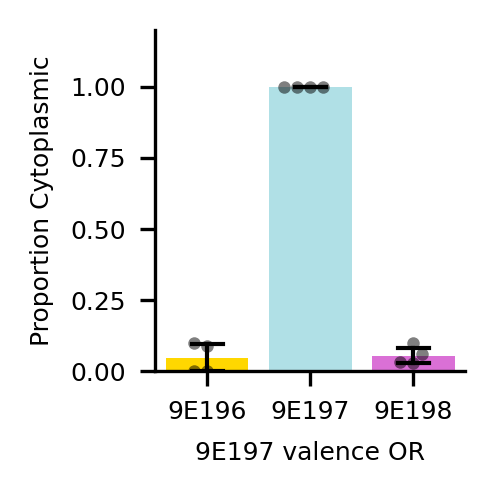

In [662]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['gold', 'powderblue', 'orchid']
cyto_norm_threshold = 0.2 
coexpression_nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

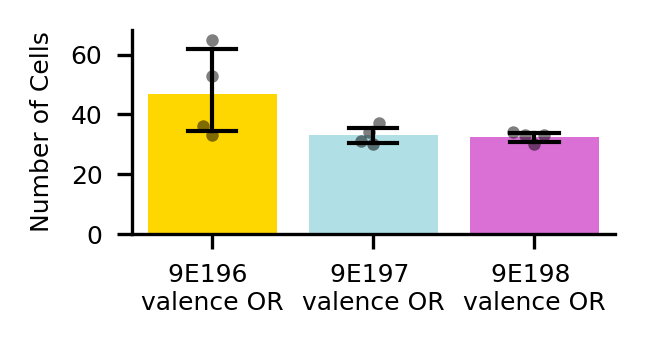

In [663]:
# Plot the number of cells 
plot_colors = ['gold', 'powderblue', 'orchid']
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(2.25, 1.25), dpi = 300) 
sns.barplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, palette=plot_colors, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [664]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 4 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 102, 4, 2048, 2048)
Loaded ../results/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 4 great_rois.npy
Loaded ../results/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 4 great_cell_borders.npy


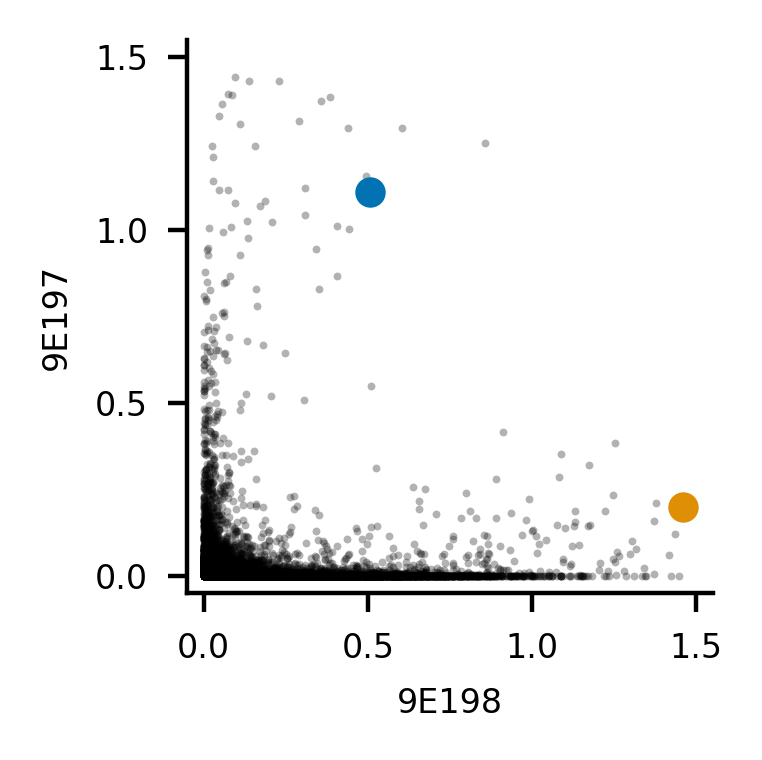

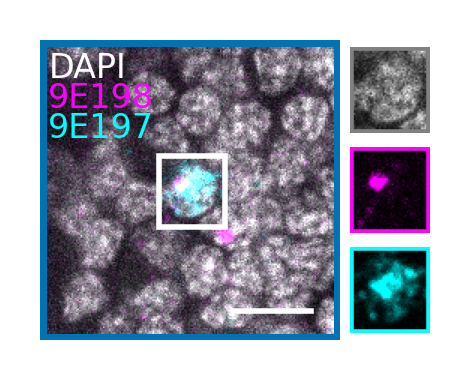

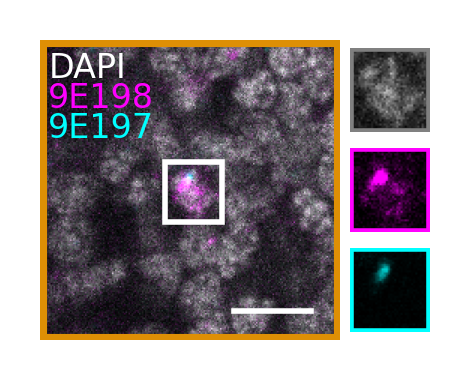

In [665]:
# 9e198-b3-488 9e197-b1-546 9e196-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF546-nuc-norm", 
                c1_name="9E198", c2_name="9E197",
                c1_color="magenta", c2_color="cyan",
                coordinates=[[0.4, 1.2], [1.4, 0.3]],
                dapi_max=255, c1_max=100, c2_max=100)

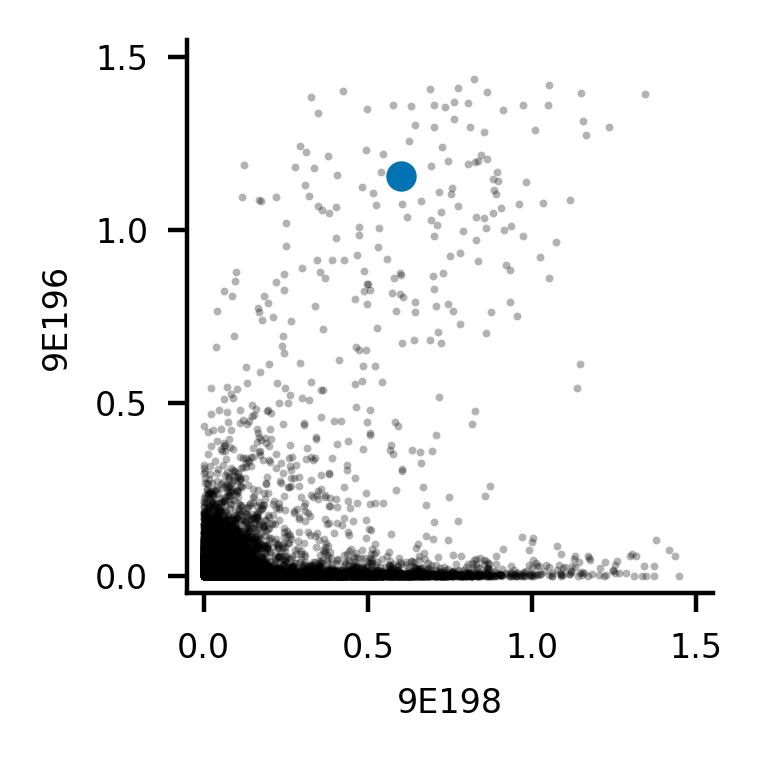

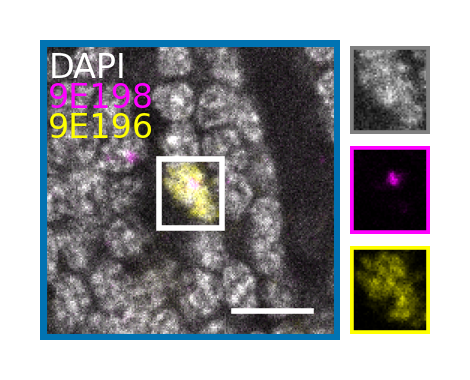

In [666]:
# 9e198-b3-488 9e197-b1-546 9e196-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="9E198", c2_name="9E196",
                c1_color="magenta", c2_color="yellow",
                coordinates=[[0.6, 1.2]],
                dapi_max=255, c1_max=255, c2_max=255)

## LOC104 & 9E129

In [667]:
input = '9E129'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi as input directory


In [668]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [669]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E129", "LOC105275104", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [530]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)

# Assign cytoplasmic annotations based on border pixels, nuclear area, normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > valence_OR_border_threshold) & (results['nucleus_area'] > valence_OR_nuc_norm_threshold) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)

manual_cytoplasmic_channels = results['cytoplasmic'].value_counts().index.tolist()
for channel in manual_cytoplasmic_channels: 
    num_cells = results[results['cytoplasmic'] == channel].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation: {num_cells}")
    num_cells_with_valence_OR = results[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'])].shape[0]
    print(f"Number of cells with {channel} cytoplasmic annotation and valence OR annotation: {num_cells_with_valence_OR}")
    nuc_norm = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-nuc-norm"].mean()
    print(f"Missing cells mean {channel} nucleus normalized signal: {nuc_norm:.2f}")
    rel_cyto = results.loc[(results['cytoplasmic'] == channel) & (results[f'{channel}-cytoplasmic'] == False)][f"{channel}-cyto-norm"].mean()
    print(f"Missing cells mean {channel} cytoplasmic normalized signal: {rel_cyto:.2f}")


results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF647 cytoplasmic annotation: 187
Number of cells with AF647 cytoplasmic annotation and valence OR annotation: 139
Missing cells mean AF647 nucleus normalized signal: 0.56
Missing cells mean AF647 cytoplasmic normalized signal: 0.42
Number of cells with AF488 cytoplasmic annotation: 108
Number of cells with AF488 cytoplasmic annotation and valence OR annotation: 77
Missing cells mean AF488 nucleus normalized signal: 0.71
Missing cells mean AF488 cytoplasmic normalized signal: 0.20


image   z  z_id  border_pxls  nucleus_area  \
0     20250328 4 KLF sample 4.czi  20     1          171         232.0   
1     20250328 4 KLF sample 4.czi  29   200          273         713.0   
2     20250328 4 KLF sample 4.czi  31   256          269         407.0   
3     20250328 4 KLF sample 4.czi  33   112          118         283.0   
4     20250328 4 KLF sample 4.czi  39   203          137         533.0   
...                           ...  ..   ...          ...           ...   
1015  20250328 4 KLF sample 1.czi  71   203          101         297.0   
1016  20250328 4 KLF sample 1.czi  72   119          197         717.0   
1017  20250328 4 KLF sample 1.czi  72   192          199         736.0   
1018  20250328 4 KLF sample 1.czi  73   120          184         455.0   
1019  20250328 4 KLF sample 1.czi  73   194          231         657.0   

     channel  cyto-norm cytoplasmic_channel  nuc-norm channel_name  \
0      AF488   0.364066               AF488  0.987799        9E129   
1      AF488   1.045835               AF488  1.402526        9E129   
2      AF488   1.015625               AF488  2.666573        9E129   
3      AF488   0.464293               AF488  0.770156        9E129   
4      AF488   0.507869               AF488  1.148207        9E129   
...      ...        ...                 ...       ...          ...   
1015   AF647   1.164292               AF647  0.999865        9E116   
1016   AF647   1.297309               AF647  1.457664        9E116   
1017   AF647   1.100720               AF647  1.277401        9E116   
1018   AF647   0.970714               AF647  1.000318        9E116   
1019   AF647   1.135273               AF647  1.427752        9E116   

       valence_OR_name  
0     9E129 valence OR  
1     9E129 valence OR  
2     9E129 valence OR  
3     9E129 valence OR  
4     9E129 valence OR  
...                ...  
1015  9E116 valence OR  
1016  9E116 valence OR  
1017  9E116 valence OR  
1018  9E116 valence OR  
1019  9E116 valence OR  

[2580 rows x 11 columns]

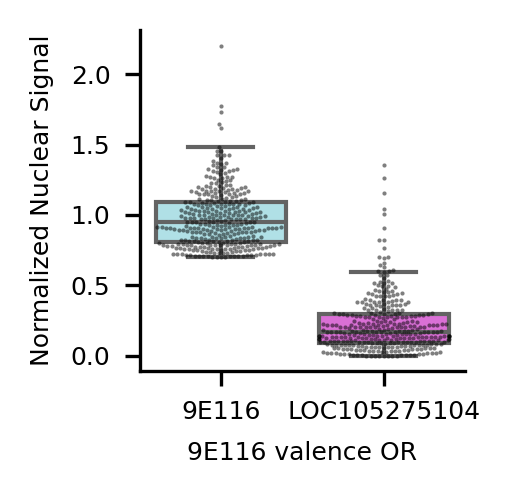

In [531]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

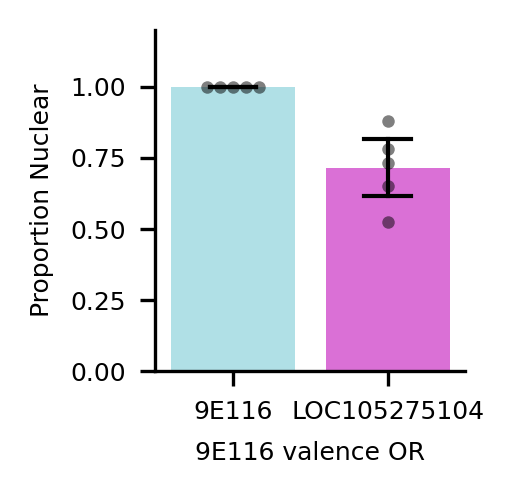

In [532]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
plot_colors = ['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

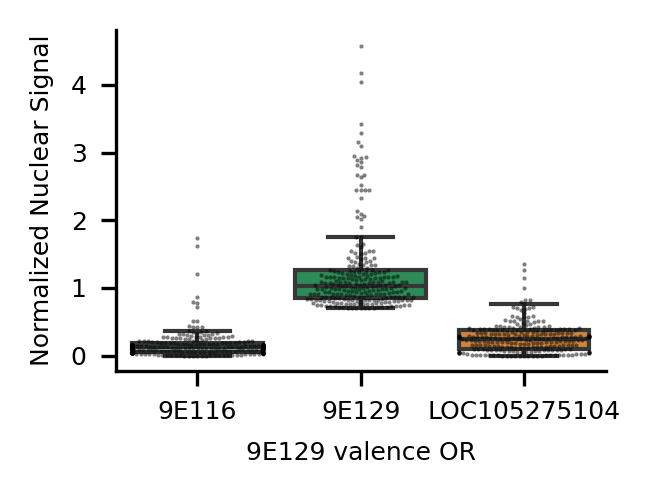

In [533]:
valence_channel = "9E129 valence OR"
channels_to_plot = ["9E116", "9E129", "LOC105275104"]
f, ax = plt.subplots(1, 1, figsize=(2.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'seagreen', 'peru'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

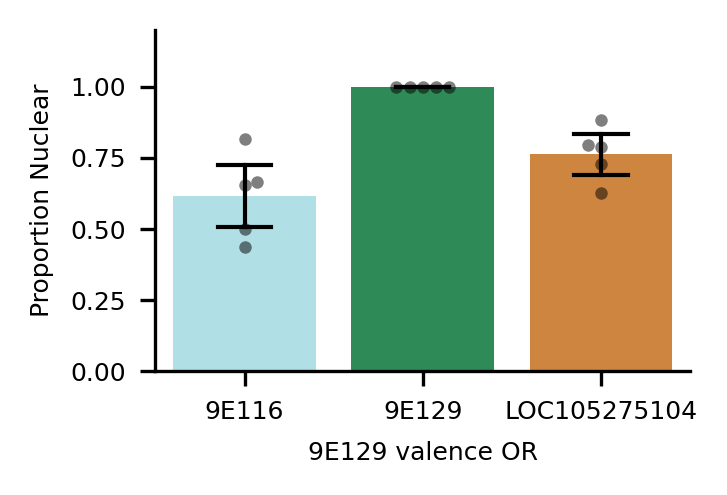

In [534]:
valence_channel = "9E129 valence OR"
channels_to_plot = ["9E116", "9E129", "LOC105275104"]
plot_colors = ['powderblue', 'seagreen', 'peru']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(2.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

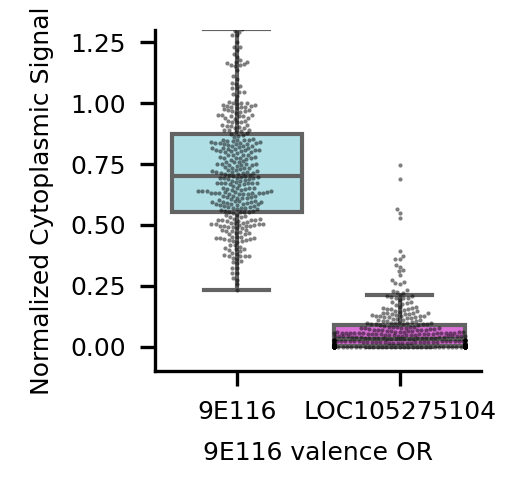

In [535]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=['powderblue', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.3)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-rel.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

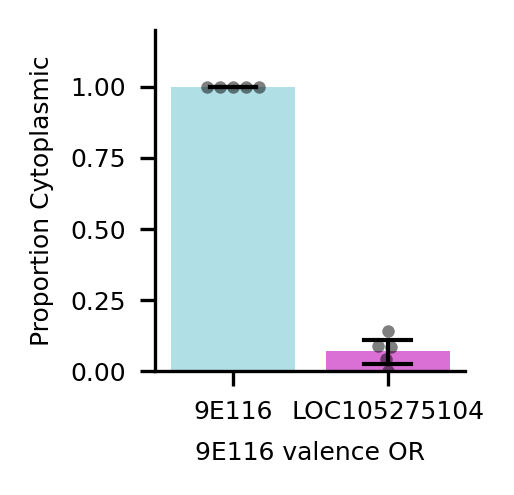

In [536]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
plot_colors = ['powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

## LOC603 & 9E108

In [537]:
input = 'LOC603'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI as input directory


In [538]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [539]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["LOC105282603", "9E108", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [540]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [541]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-norm'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [542]:
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > valence_OR_nuc_norm_threshold)
    print(f"Number of cells with {channel} cytoplasmic signal: {len(results[results[f'{channel}-cytoplasmic']])}")

results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic celsl melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls'])

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['valence_OR_name'] = melted_merged['valence_OR_name'] + " valence OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)
results_melted

Number of cells with AF488 cytoplasmic signal: 338
Number of cells with AF546 cytoplasmic signal: 315
Number of cells with AF647 cytoplasmic signal: 432


image   z  z_id  border_pxls channel  cyto-norm  \
0     20250328 5 ZP sample 2.czi   1     1          161   AF488   0.319802   
1     20250328 5 ZP sample 2.czi  41   459          196   AF488   1.332467   
2     20250328 5 ZP sample 2.czi  43   114          152   AF488   0.206217   
3     20250328 5 ZP sample 2.czi  43   441          193   AF488   0.660970   
4     20250328 5 ZP sample 2.czi  44   462          199   AF488   0.571307   
...                          ...  ..   ...          ...     ...        ...   
1291  20250328 5 ZP sample 4.czi  66   287          280   AF647   0.437556   
1292  20250328 5 ZP sample 4.czi  67   100          181   AF647   0.970268   
1293  20250328 5 ZP sample 4.czi  68    75          171   AF647   0.998753   
1294  20250328 5 ZP sample 4.czi  69    65          164   AF647   1.109802   
1295  20250328 5 ZP sample 4.czi  71   146          214   AF647   0.709786   

     cytoplasmic_channel  nuc-norm  channel_name          valence_OR_name  
0                  AF488  0.985280  LOC105282603  LOC105282603 valence OR  
1                  AF488  0.701199  LOC105282603  LOC105282603 valence OR  
2                  AF488  0.891697  LOC105282603  LOC105282603 valence OR  
3                  AF488  1.537913  LOC105282603  LOC105282603 valence OR  
4                  AF488  1.540378  LOC105282603  LOC105282603 valence OR  
...                  ...       ...           ...                      ...  
1291               AF647  0.794193         9E116         9E116 valence OR  
1292               AF647  1.223492         9E116         9E116 valence OR  
1293               AF647  1.158479         9E116         9E116 valence OR  
1294               AF647  1.001290         9E116         9E116 valence OR  
1295               AF647  1.015918         9E116         9E116 valence OR  

[3255 rows x 10 columns]

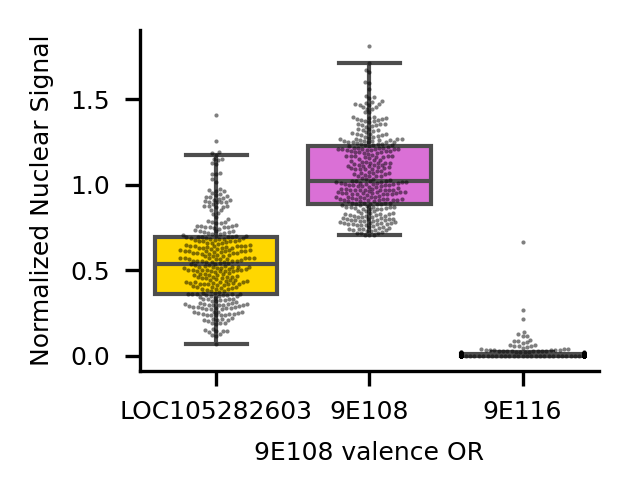

In [543]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108", "9E116"]
f, ax = plt.subplots(1, 1, figsize=(2.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

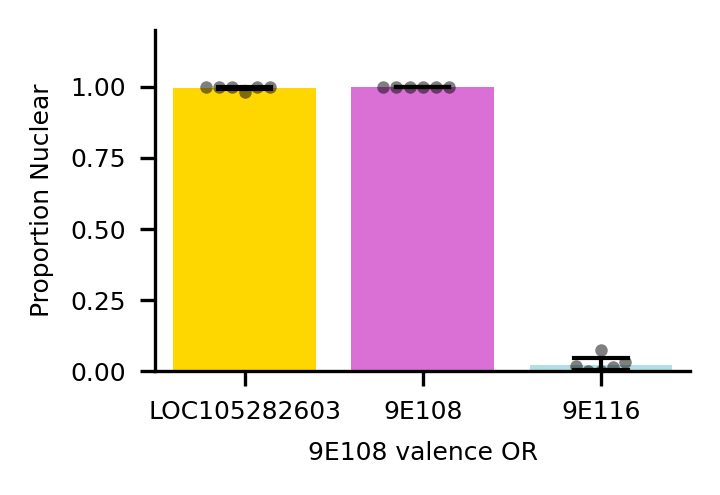

In [544]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108", "9E116"]
plot_colors = ['gold', 'orchid', 'powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(2.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

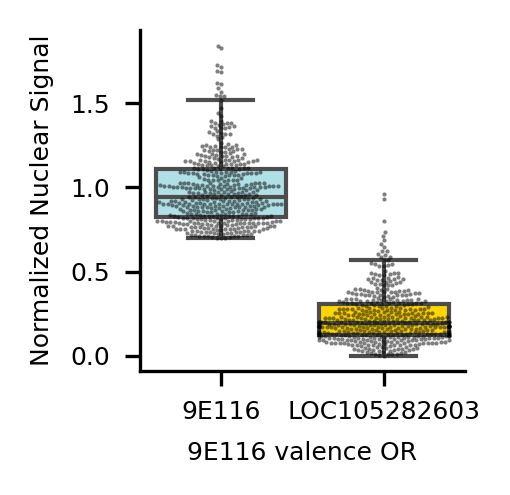

In [545]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'gold', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

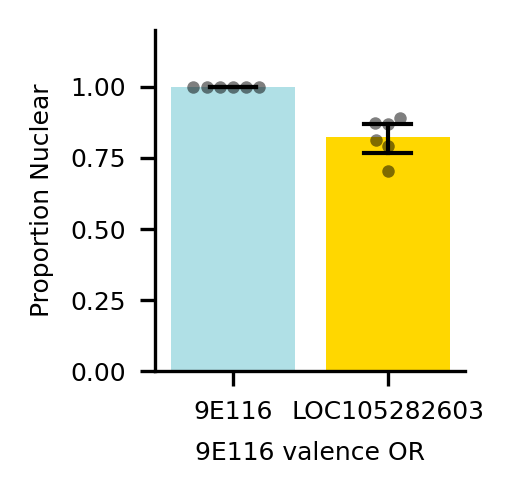

In [546]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
plot_colors = ['powderblue', 'gold', 'powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

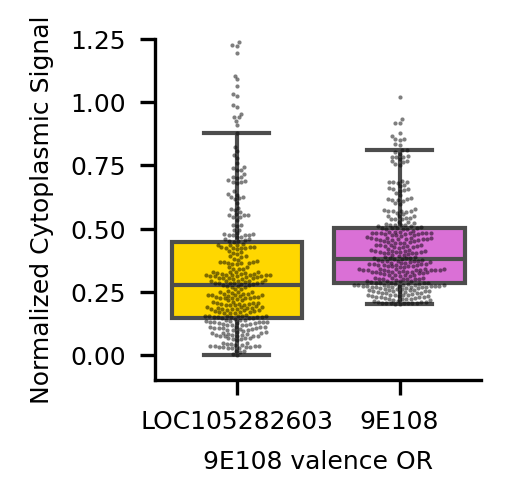

In [547]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108"]
f, ax = plt.subplots(1, 1, figsize=(1.75 , 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=['gold', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.25)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

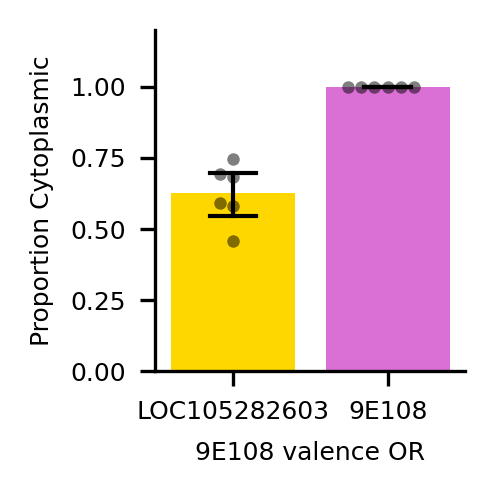

In [548]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108"]
plot_colors = ['gold', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

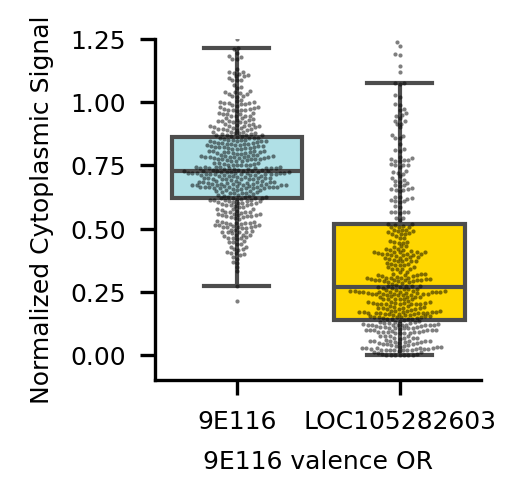

In [549]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
f, ax = plt.subplots(1, 1, figsize=(1.75 , 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, palette=['powderblue', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.25)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

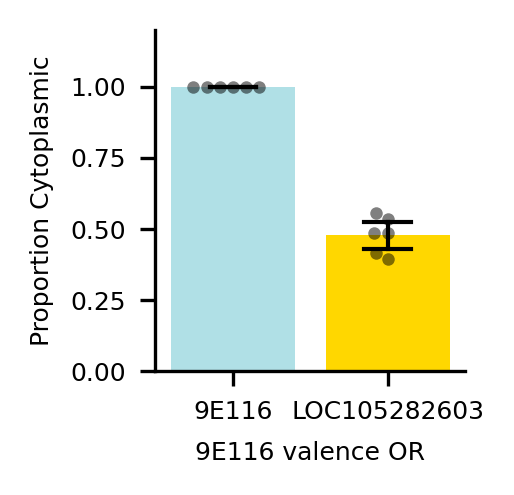

In [550]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
plot_colors = ['powderblue', 'gold']
cyto_norm_threshold = 0.2 
coexpression_nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-norm'] > cyto_norm_threshold) & (x['nuc-norm'] > coexpression_nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-norm'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [551]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 4.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 85, 4, 2048, 2048)
Loaded ../results/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 4_rois.npy
Loaded ../results/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 4_cell_borders.npy


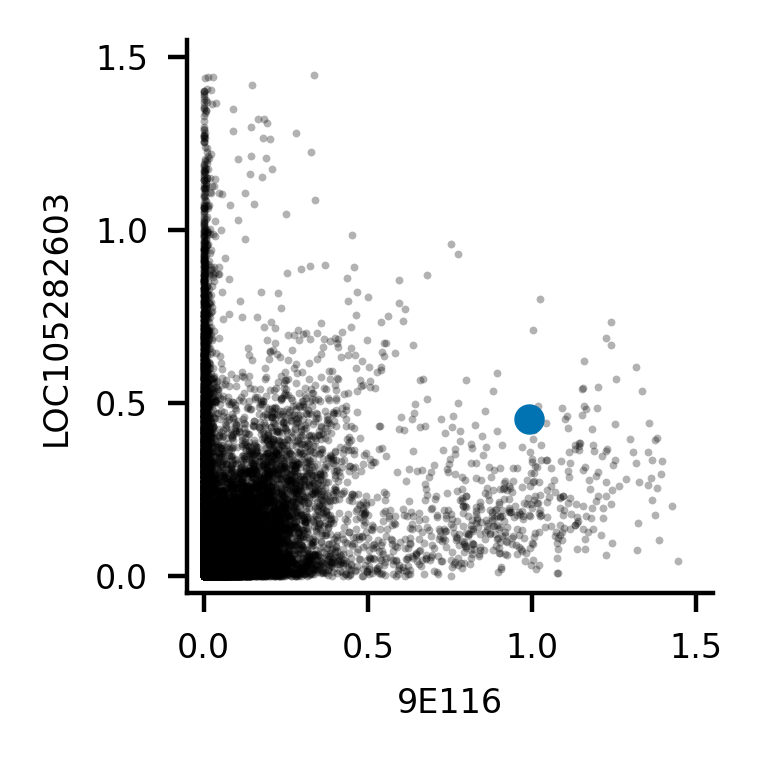

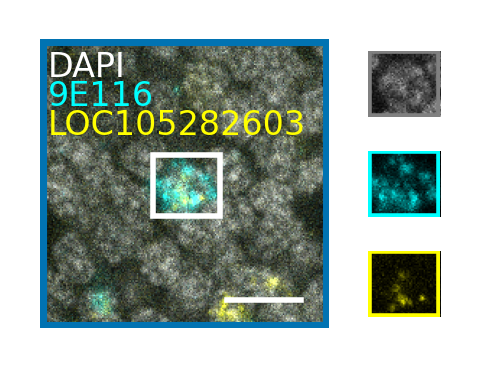

In [552]:
# LOC603-b3-488 9E108-b1-546 9E116-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF647-nuc-norm", c2="AF488-nuc-norm", 
                c1_name="9E116", c2_name="LOC105282603",
                c1_color="cyan", c2_color="yellow",
                coordinates=[[0.95, 0.5]], bbox_expansion=7, 
                dapi_max=255, c1_max=150, c2_max=150)